<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Load Data

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
df = pd.DataFrame(house)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Exploration (EDA)

In [4]:
df.shape

(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
### To get a better look at the data I have created a DF describing the data
# Get the column name, number of unique variables and the variable type for each column
def column_info(df):
    cols_info = [[col, df[col].dtype, df[col].unique(), df[col].nunique()] for col in df.columns]

    # add info to a DF
    df_cols_info = pd.DataFrame(cols_info, columns=['variable' ,'type','unique','total'])

    cols_info_list =  [df[column].values for column in df.columns] # create a list of the variables for each column

    #df_cols_info['values'] = cols_info_list  # add values list to DF

    null_list = [df[column].isnull().sum() for column in df.columns] # calculate number of null values in column
    df_cols_info['null'] = null_list
    
    return df_cols_info
#df_cols_info[df_cols_info['type'] == object]

In [7]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Create new column for years since renovation

In [8]:
df['YrSinceRemod'] = df['YearRemodAdd']- df['YearBuilt']
df['YrSinceRemod'].value_counts()

def r(x):
    if x == 0:
        return 0
    elif x >=1:
        return 1


df['Reno'] = df['YrSinceRemod'].apply(r)
#df['has_Pool'] = df['PoolArea'].apply(r)
yn_cols = ['PoolArea','GarageArea','Fireplaces','BsmtFinSF1']

for col in yn_cols:
    new_col_name = 'has_'+col
    df[new_col_name] = df[col].apply(r)
    
#df.columns   

#### Select features that cannot be renovated

In [9]:
# fixed feature columns for residential df - characteristics of the house that cannot be renovated
res_cols = [
    'MSSubClass', 'MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities',
 'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt',
    'RoofStyle','MasVnrType','MasVnrArea','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1',
 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','CentralAir','1stFlrSF','2ndFlrSF','LowQualFinSF',
 'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
 'Fireplaces','FireplaceQu','GarageType','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',
 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal','MoSold',
 'YrSold','SaleType','SaleCondition','SalePrice','YrSinceRemod','Reno','has_GarageArea', 'has_Fireplaces'
]
#text_file = open("/home/dsi-student/GA-DSI-Unit/unit_3_project/fixed_features.txt", "r")
#fixed_features = text_file.read().split('\n')
#res_cols = [f for f in fixed_features]
#res_cols.remove('')
#res_cols

#### Select Residential properties

In [10]:
res_df = pd.DataFrame(df)
res_df = res_df[ (res_df['MSZoning'] == 'RL') | (res_df['MSZoning'] == 'RH') | (res_df['MSZoning'] == 'RP') | (res_df['MSZoning'] == 'RM')]

res_df = res_df[res_cols]
res_df.shape

(1385, 63)

#### Explore variable types, values, nulls

In [11]:
colinf=column_info(res_df)
objs = colinf[colinf['type'] == object] #.sort_values(by='total')
objs = objs['variable'].values

colinf.sort_values(by='variable', ascending=False)

,variable,type,unique,total,null
61,has_GarageArea,int64,"[1, 0]",2,0
62,has_Fireplaces,int64,"[0, 1]",2,0
55,YrSold,int64,"[2008, 2007, 2006, 2009, 2010]",5,0
59,YrSinceRemod,int64,"[0, 1, 55, 2, 19, 11, 72, 7, 20, 33, 49, 40, 2...",109,0
16,YearBuilt,int64,"[2003, 1976, 2001, 1915, 2000, 1993, 2004, 197...",112,0
46,WoodDeckSF,int64,"[0, 298, 192, 40, 255, 235, 90, 147, 140, 160,...",269,0
8,Utilities,object,"[AllPub, NoSeWa]",2,0
26,TotalBsmtSF,int64,"[856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...",704,0
39,TotRmsAbvGrd,int64,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]",12,0
4,Street,object,"[Pave, Grvl]",2,0


#### Calculate mean and median for sales (target variable)

In [12]:
print ('Mean sale price: {}\nMedian sale price: {}'.format(round(res_df['SalePrice'].mean(),2), round(res_df['SalePrice'].median(),2)))

Mean sale price: 180136.28
Median sale price: 160000.0


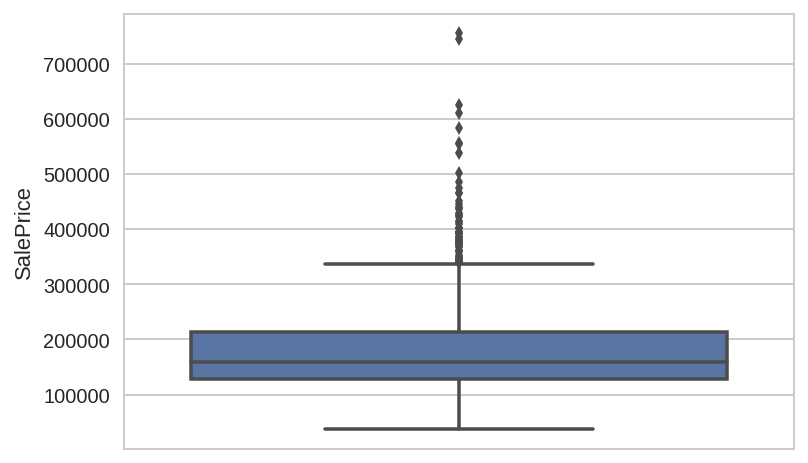

In [13]:
sns.boxplot(x='SalePrice', data=res_df, orient='v')

In [14]:
# find mean and median sales prices
neigh_mean = res_df.groupby(by='Neighborhood').mean()
neigh_med = res_df.groupby(by='Neighborhood').median()

neigh_mean = neigh_mean[['SalePrice']]
neigh_mean.columns = ['Mean Price']

neigh_med = neigh_med[['SalePrice']]
neigh_med.columns = ['Median Price']

avgs = neigh_mean.merge(neigh_med, how='right', left_index=True, right_index=True)
avgs['Difference'] = abs(avgs['Mean Price'] - avgs['Median Price'])
avgs['Mean Price'] = avgs['Mean Price'].map(lambda x : round(x,2))
avgs['Difference'] = avgs['Difference'].map(lambda x : round(x,2))
avgs.sort_values('Difference', ascending=False)

,Mean Price,Median Price,Difference
Neighborhood,,,
NoRidge,335295.32,301500.0,33795.32
StoneBr,310499.00,278000.0,32499.00
Veenker,238772.73,218000.0,20772.73
Timber,242247.45,228475.0,13772.45
ClearCr,212565.43,200250.0,12315.43
Somerst,260559.62,248328.0,12231.62
Gilbert,192854.51,181000.0,11854.51
MeadowV,98576.47,88000.0,10576.47
Crawfor,210624.73,200624.0,10000.73


## Looking at distribution of variables

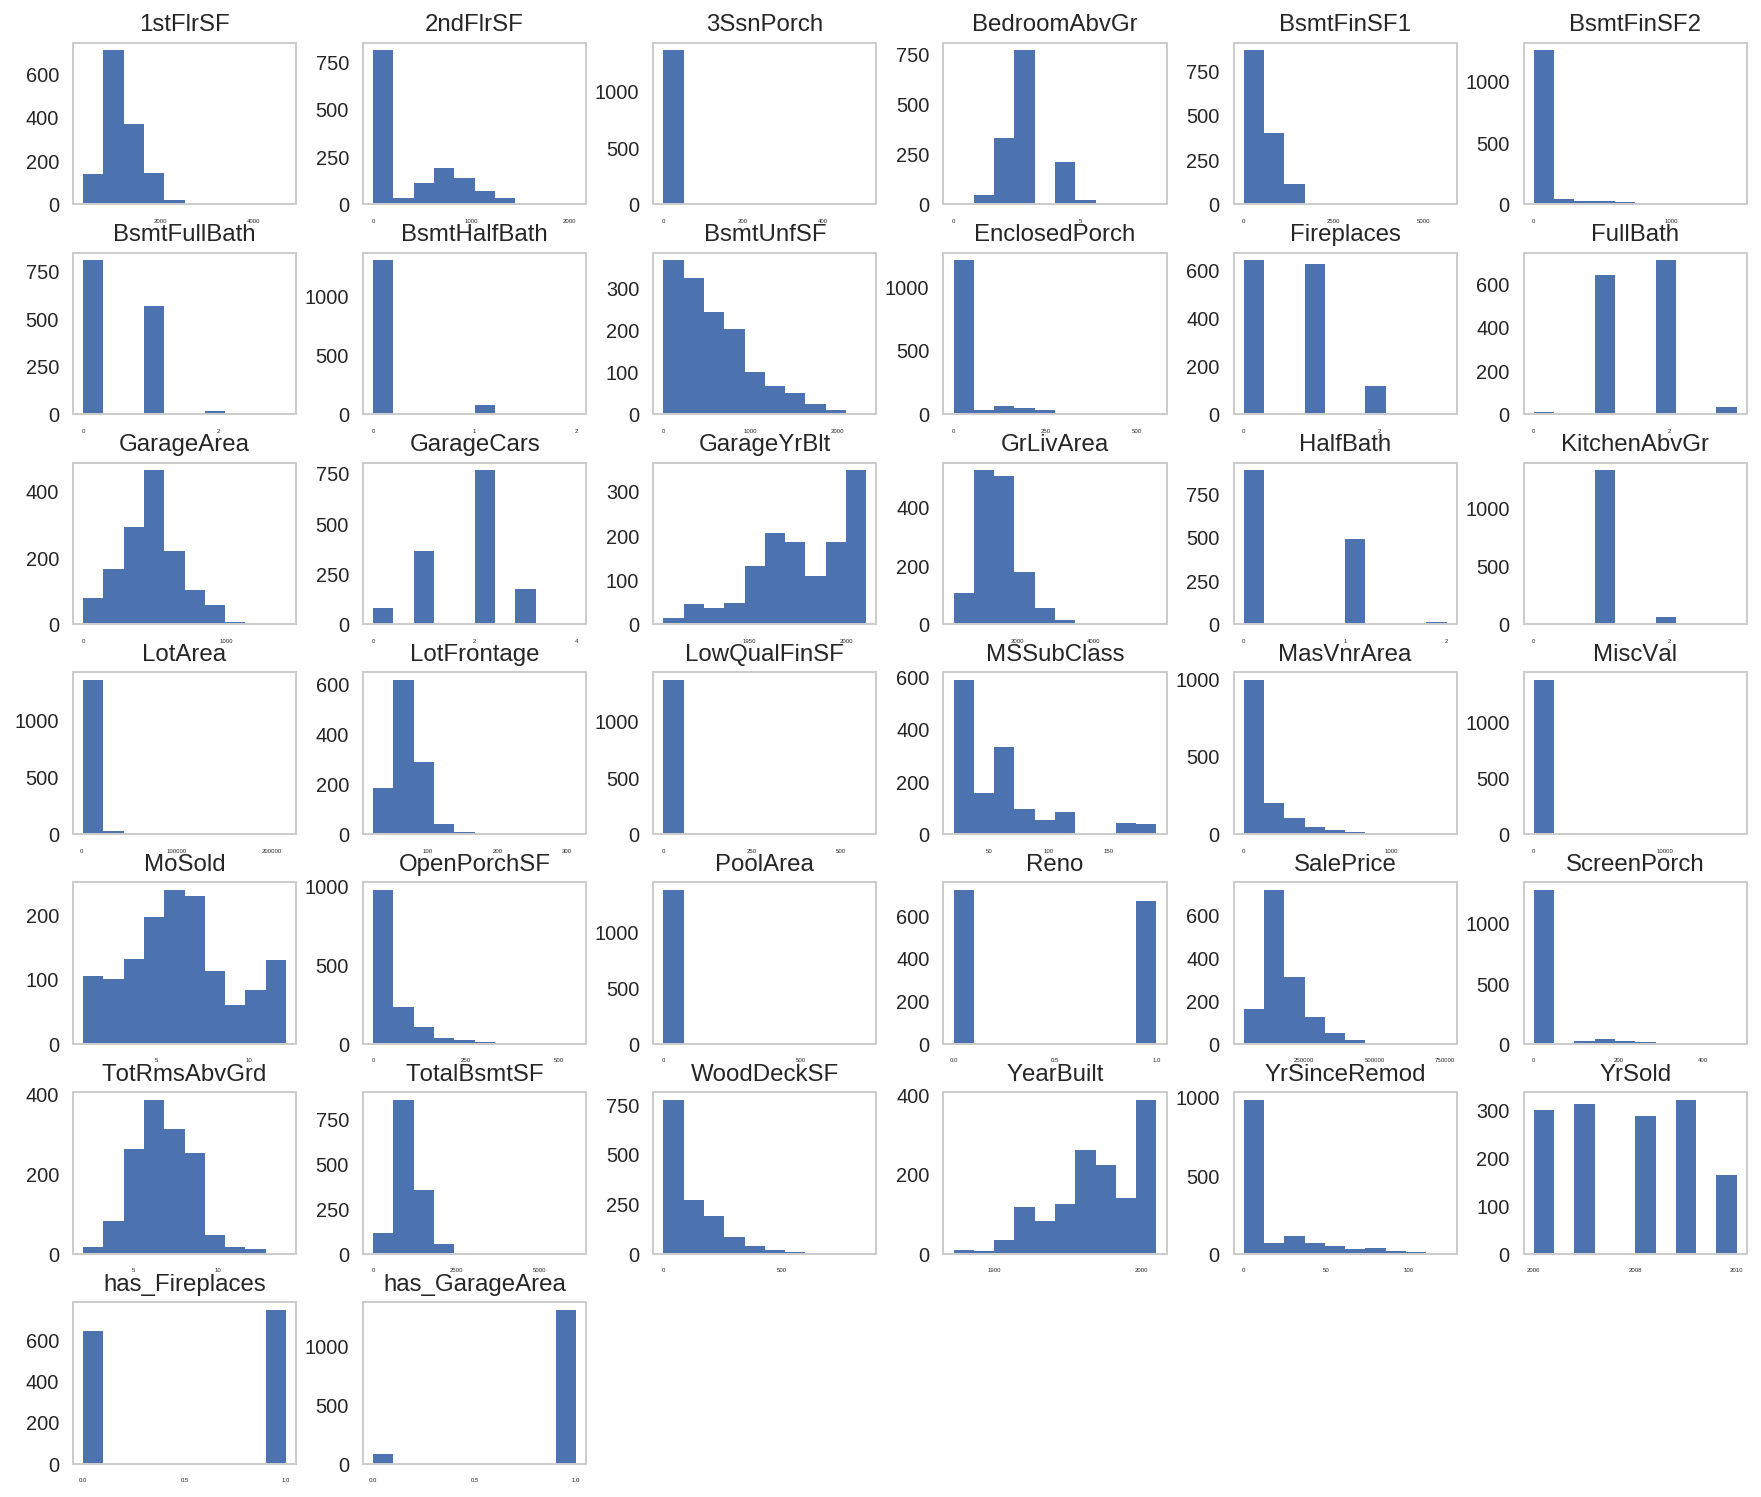

In [15]:
# Normal distribution?
dist_cols = colinf[colinf['type'] != object]
dist_cols = dist_cols['variable'].values

res_df[dist_cols].hist(figsize=(15,15), layout=(8,6), grid=False, xlabelsize=3);

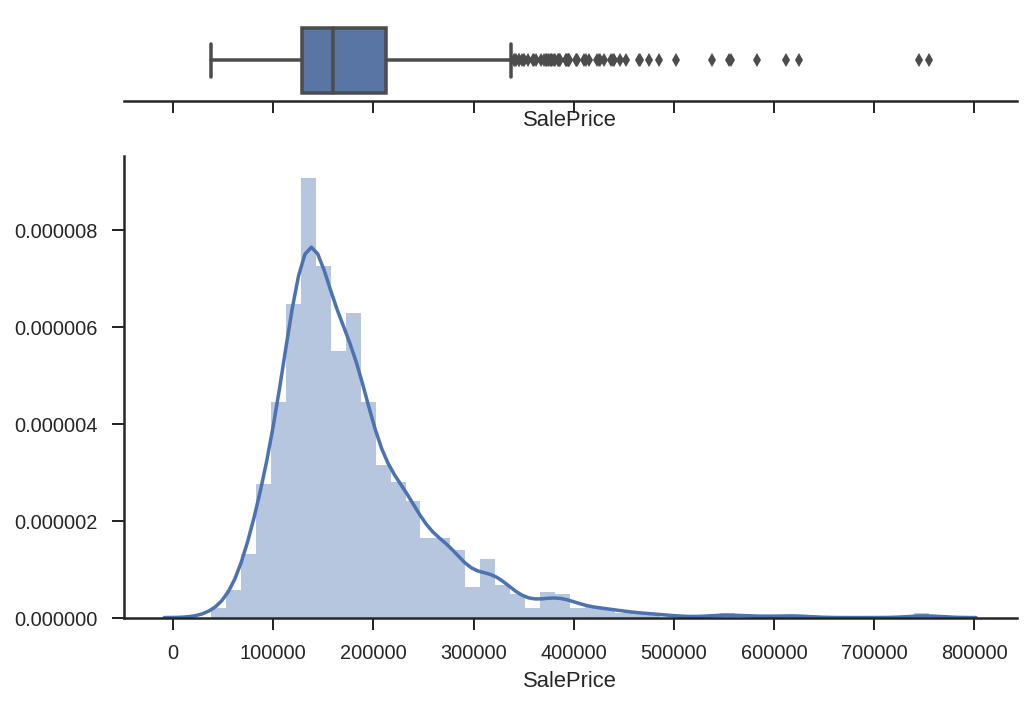

In [16]:
# Explore distribution of sales
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(res_df['SalePrice'], ax=ax_box)
sns.distplot(res_df['SalePrice'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

# most house sales are between 25,000 and 325,000
# Outliers fall between 325,000 and ~775,000

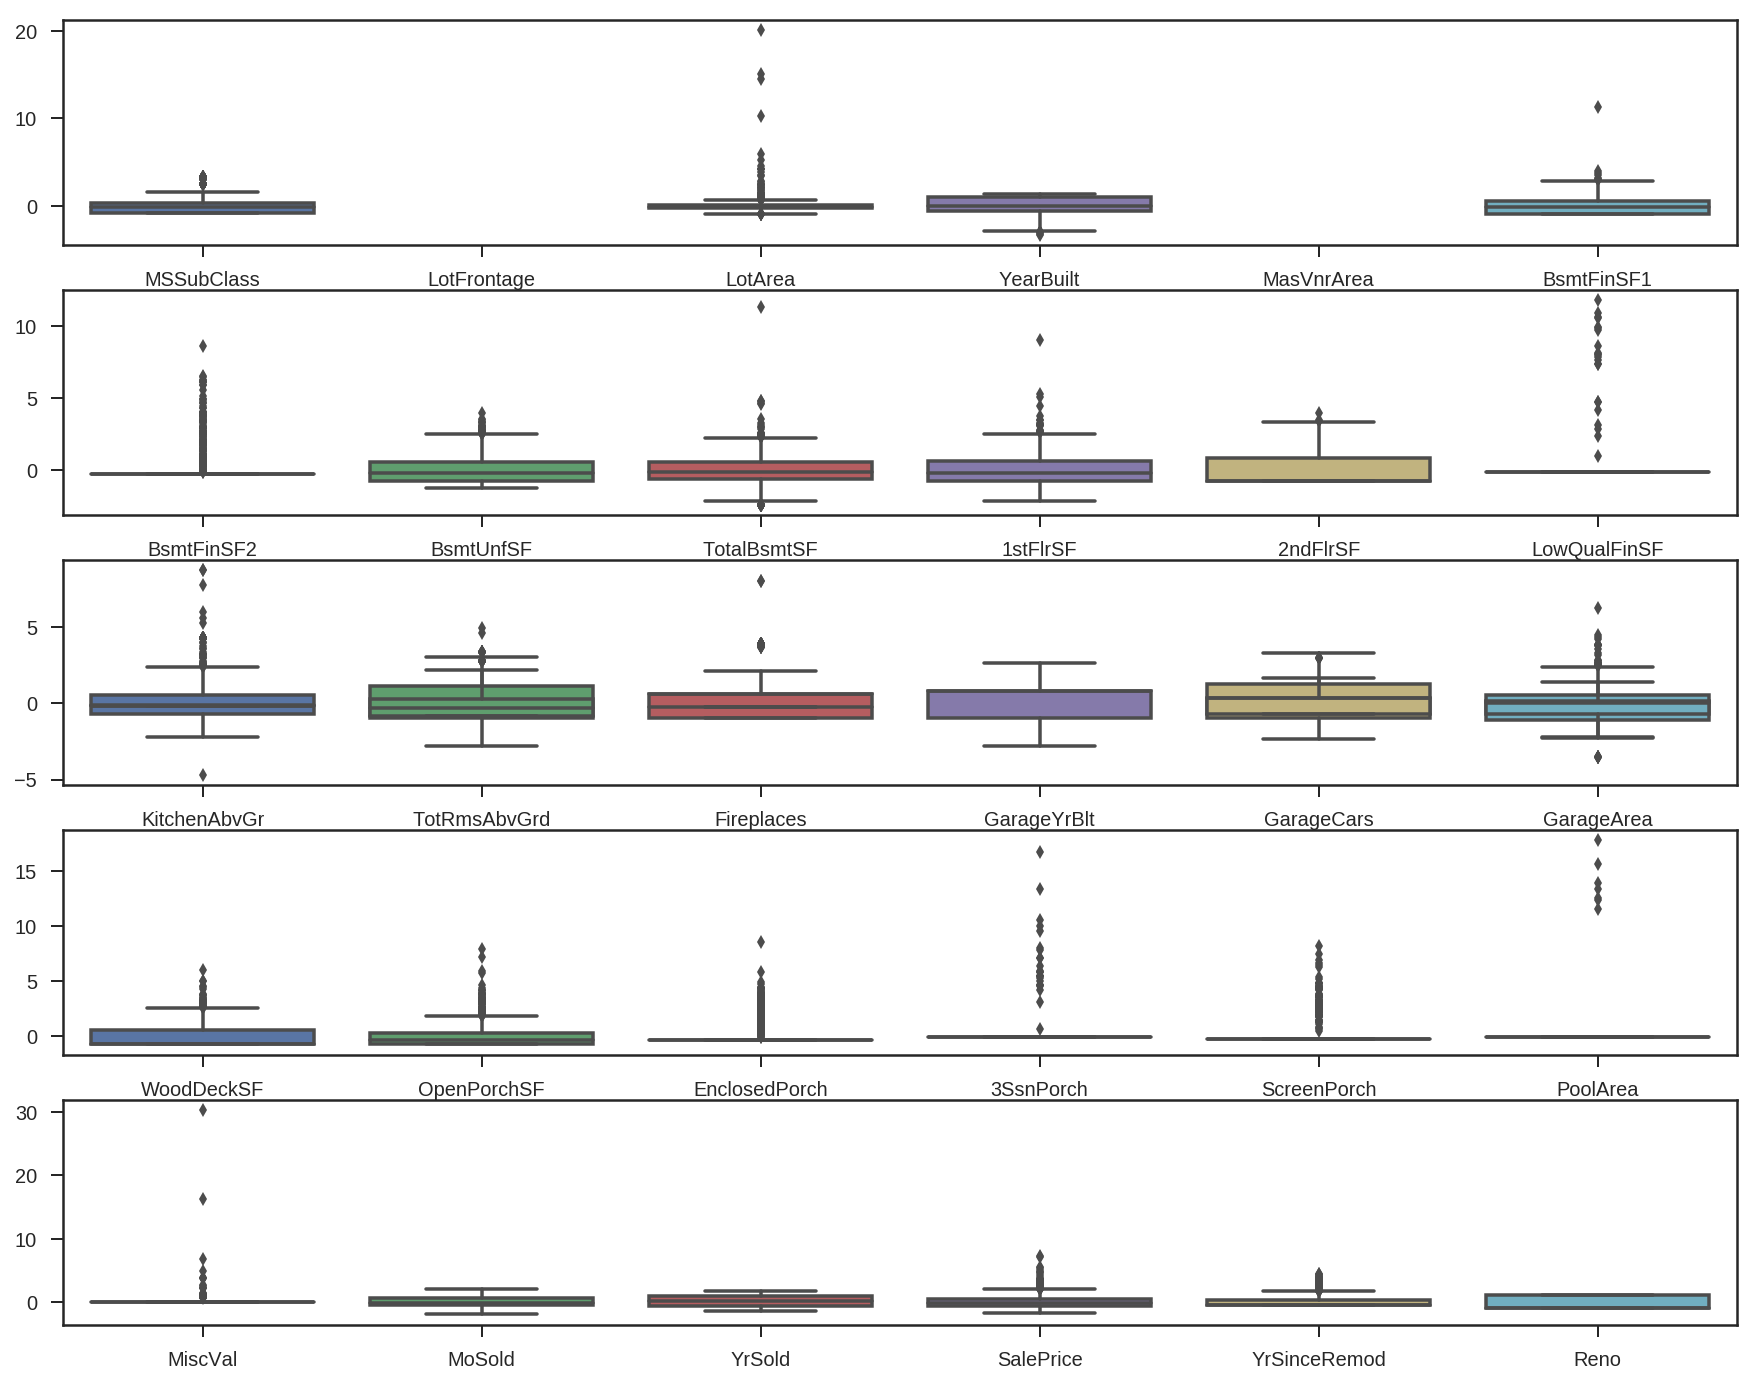

In [17]:
# What variables have outliers?
box = res_df[dist_cols].apply(stats.zscore)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(figsize=(15,12),nrows=5,ncols=1,sharey=False)
sns.boxplot(data=box.iloc[:,:6], ax=ax1);
sns.boxplot(data=box.iloc[:,6:12], ax=ax2);
sns.boxplot(data=box.iloc[:,12:18], ax=ax3);
sns.boxplot(data=box.iloc[:,18:24], ax=ax3);
sns.boxplot(data=box.iloc[:,24:30], ax=ax4);
sns.boxplot(data=box.iloc[:,30:36], ax=ax5);
#plt.xticks(rotation=45);

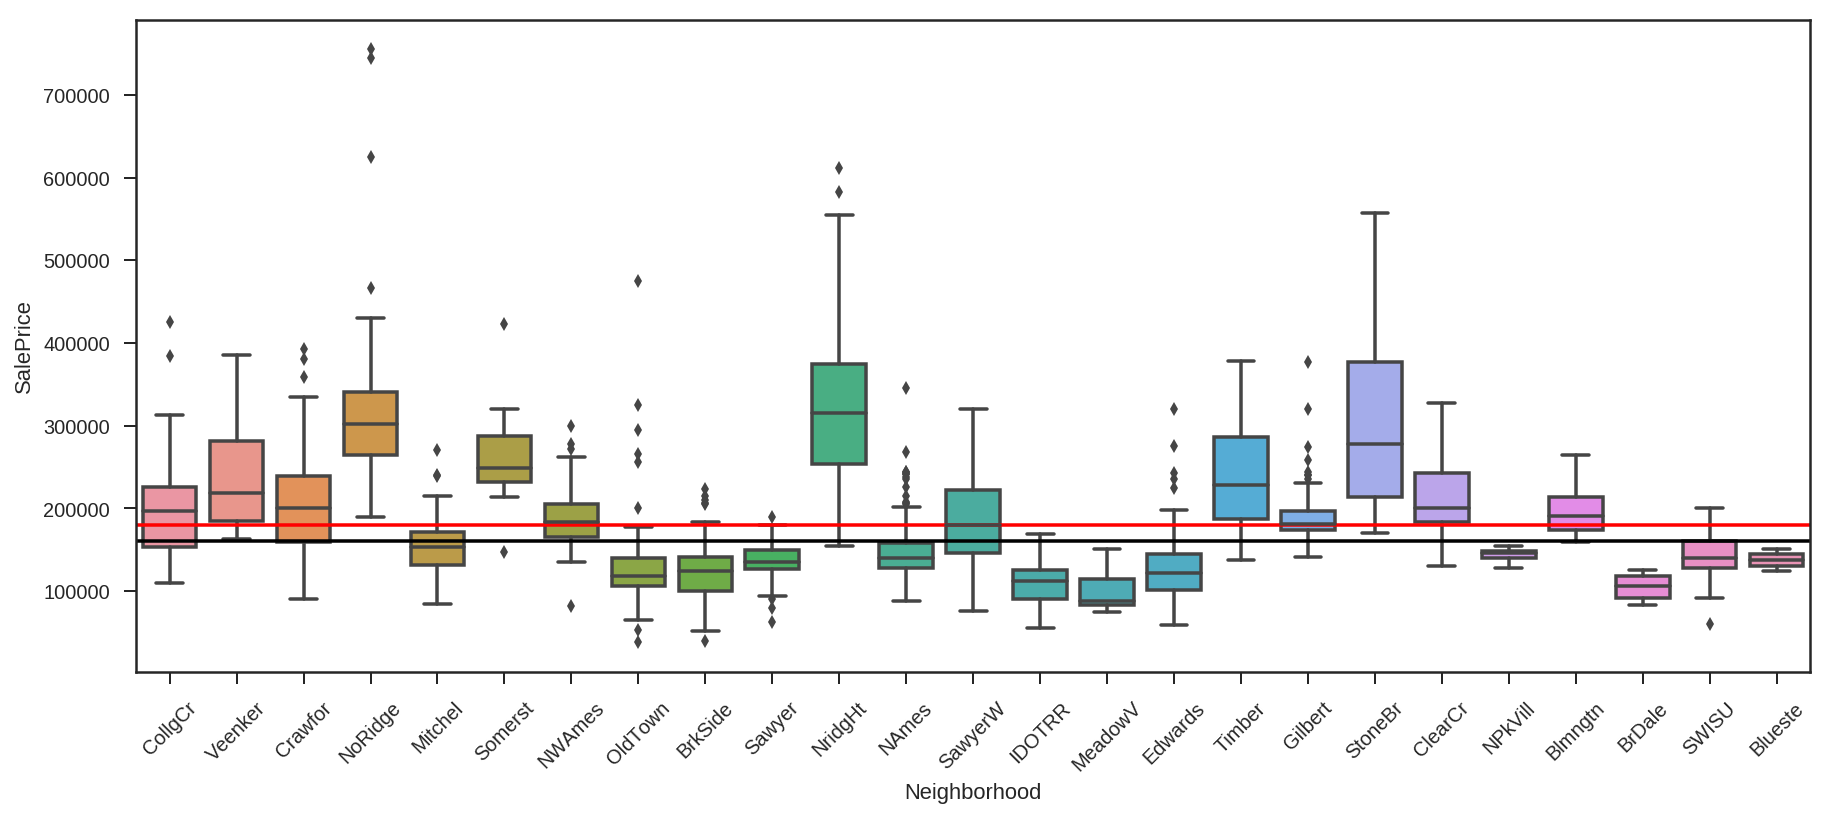

In [18]:
# Is there a difference in Sale Price based on neighborhood
ax, fig = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x='Neighborhood', y="SalePrice", data=res_df);
plt.xticks(rotation=45);

# plot mean and median line
x= plt.gca().axes.get_xlim()
mean = res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# There appears to be a difference in price for some neighbournoods

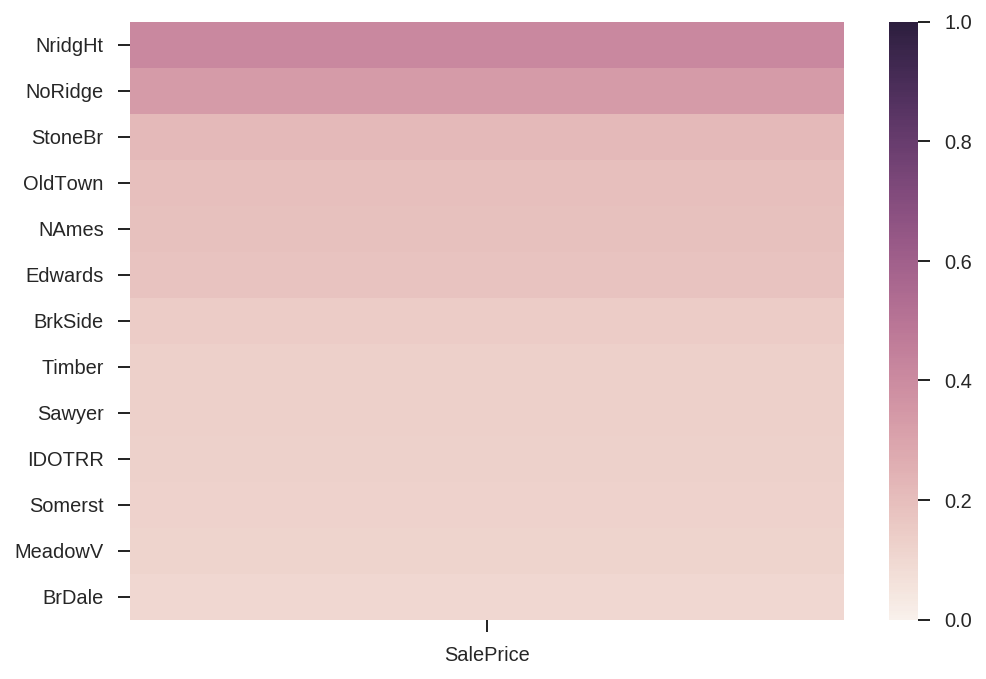

In [19]:
# What neighbourhoods are correlated with price?
test_df = pd.DataFrame(res_df.loc[:,'SalePrice'])
test_df['Neighborhood'] = res_df['Neighborhood']
test_df = pd.get_dummies(data = test_df,columns=['Neighborhood'], prefix='',prefix_sep='')
abs_neigh_corr = abs(test_df.corr())
abs_neigh_corr = abs_neigh_corr[['SalePrice']]
abs_neigh_corr = abs_neigh_corr[abs_neigh_corr['SalePrice'] > .1].sort_values(by='SalePrice',axis=0,ascending=False)

sns.heatmap(abs_neigh_corr[1:], vmin=0, vmax=1);

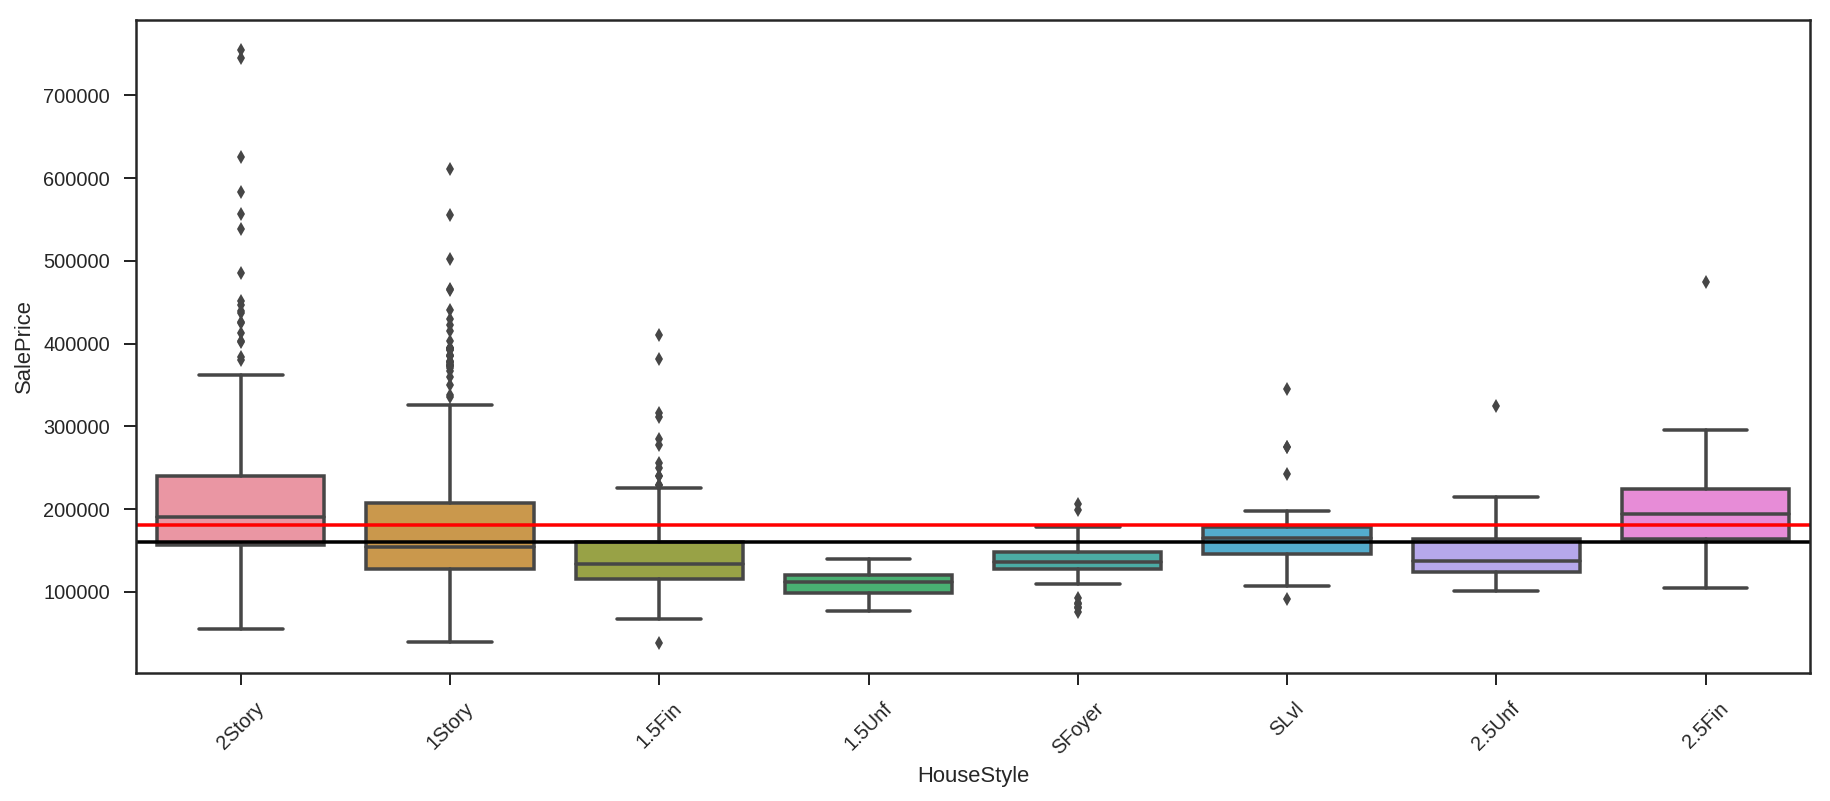

In [20]:
# Is there a difference in price for the style of a home?
ax, fig = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x='HouseStyle', y="SalePrice", data=res_df);
plt.xticks(rotation=45);

# plot mean and median line
x= plt.gca().axes.get_xlim()
mean = res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# Two story houses and 2.5 story finished houses received the highest prices while
# 1.5 story houses with unfinished upstaires received the least..

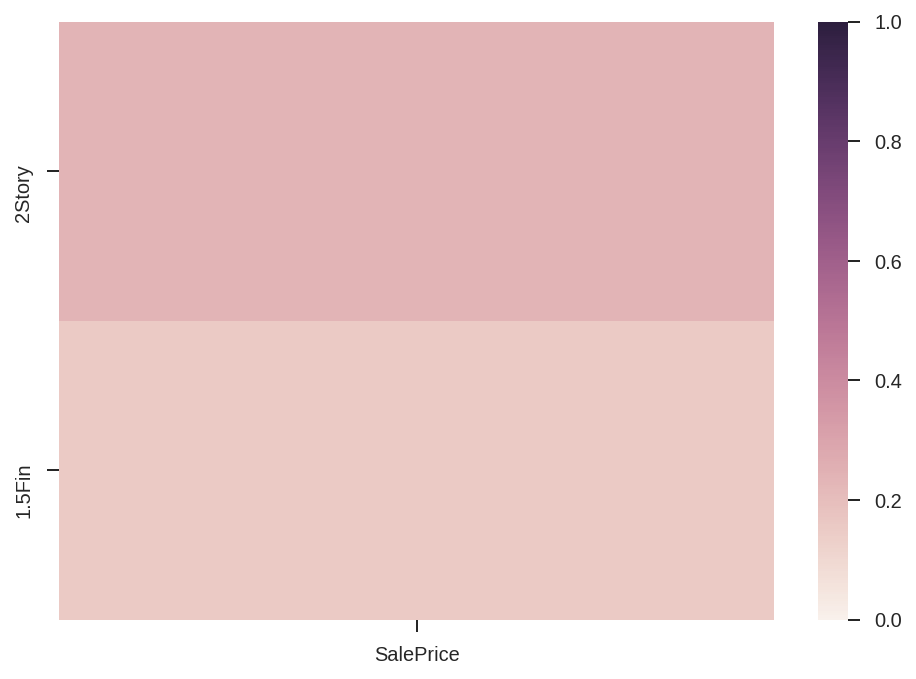

In [21]:
test_df = pd.DataFrame(res_df.loc[:,'SalePrice'])
test_df['HouseStyle'] = res_df['HouseStyle']
test_df = pd.get_dummies(data = test_df,columns=['HouseStyle'], prefix='',prefix_sep='')
abs_neigh_corr = abs(test_df.corr())
abs_neigh_corr = abs_neigh_corr[['SalePrice']]
abs_neigh_corr = abs_neigh_corr[abs_neigh_corr['SalePrice'] > .1].sort_values(by='SalePrice',axis=0,ascending=False)

sns.heatmap(abs_neigh_corr[1:], vmin=0, vmax=1);
# Very low correlation between house style and sale price

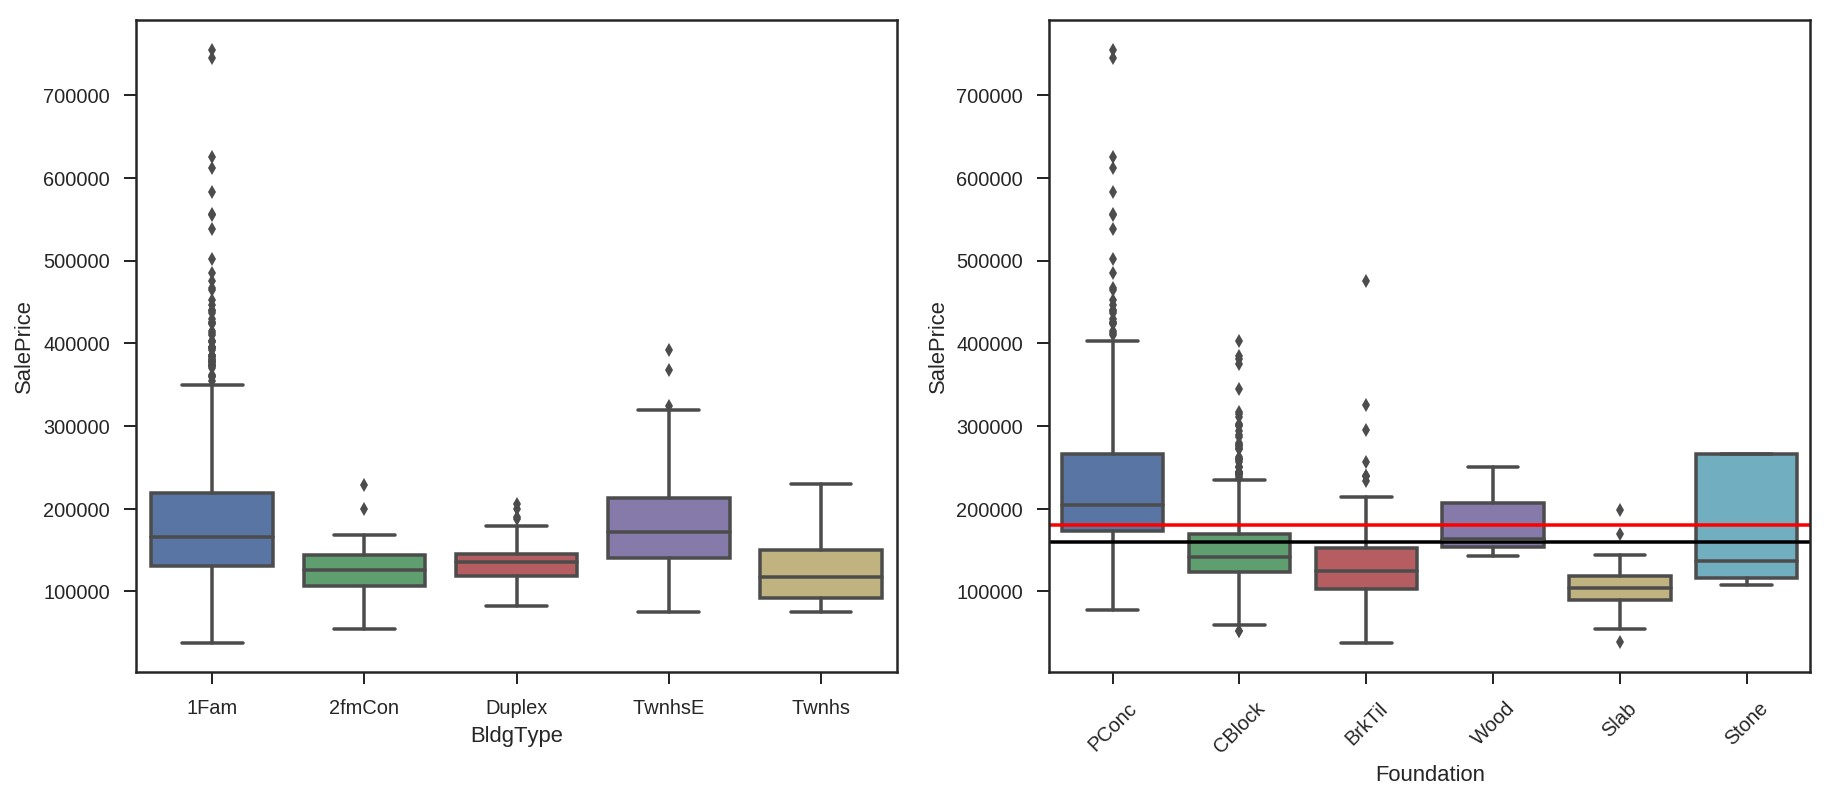

In [22]:
# Is there a difference in price between building types and foundation?
fig, (ax1,ax2) = plt.subplots(figsize=(15,6),nrows=1, ncols=2)

sns.boxplot(x='BldgType', y="SalePrice", data=res_df,ax=ax1);
plt.xticks(rotation=45);

sns.boxplot(x='Foundation', y="SalePrice", data=res_df, ax=ax2);
plt.xticks(rotation=45);

# plot mean and median line
x= plt.gca().axes.get_xlim()
mean = res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# Not much of a difference is noticible between different bulding types
# But there are some outlies for 1 Family detached houses receiving more than the median amount

In [23]:
bldg_df = pd.DataFrame(res_df.loc[:,'SalePrice'])
bldg_df['BldgType'] = res_df['BldgType']
bldg_df = pd.get_dummies(data = bldg_df, columns=['BldgType'], prefix='',prefix_sep='')
abs_bldg_corr = abs(bldg_df.corr())
abs_bldg_corr = abs_bldg_corr[['SalePrice']]
abs_bldg_corr = abs_bldg_corr[abs_bldg_corr['SalePrice'] > .0].sort_values(by='SalePrice',axis=0,ascending=False)


foun_df = pd.DataFrame(res_df.loc[:,'SalePrice'])
foun_df['Foundation'] = res_df['Foundation']
foun_df = pd.get_dummies(data = foun_df, columns=['Foundation'], prefix='',prefix_sep='')
abs_foun_corr = abs(foun_df.corr())
abs_foun_corr = abs_foun_corr[['SalePrice']]
abs_foun_corr = abs_foun_corr[abs_foun_corr['SalePrice'] > .0].sort_values(by='SalePrice',axis=0,ascending=False)

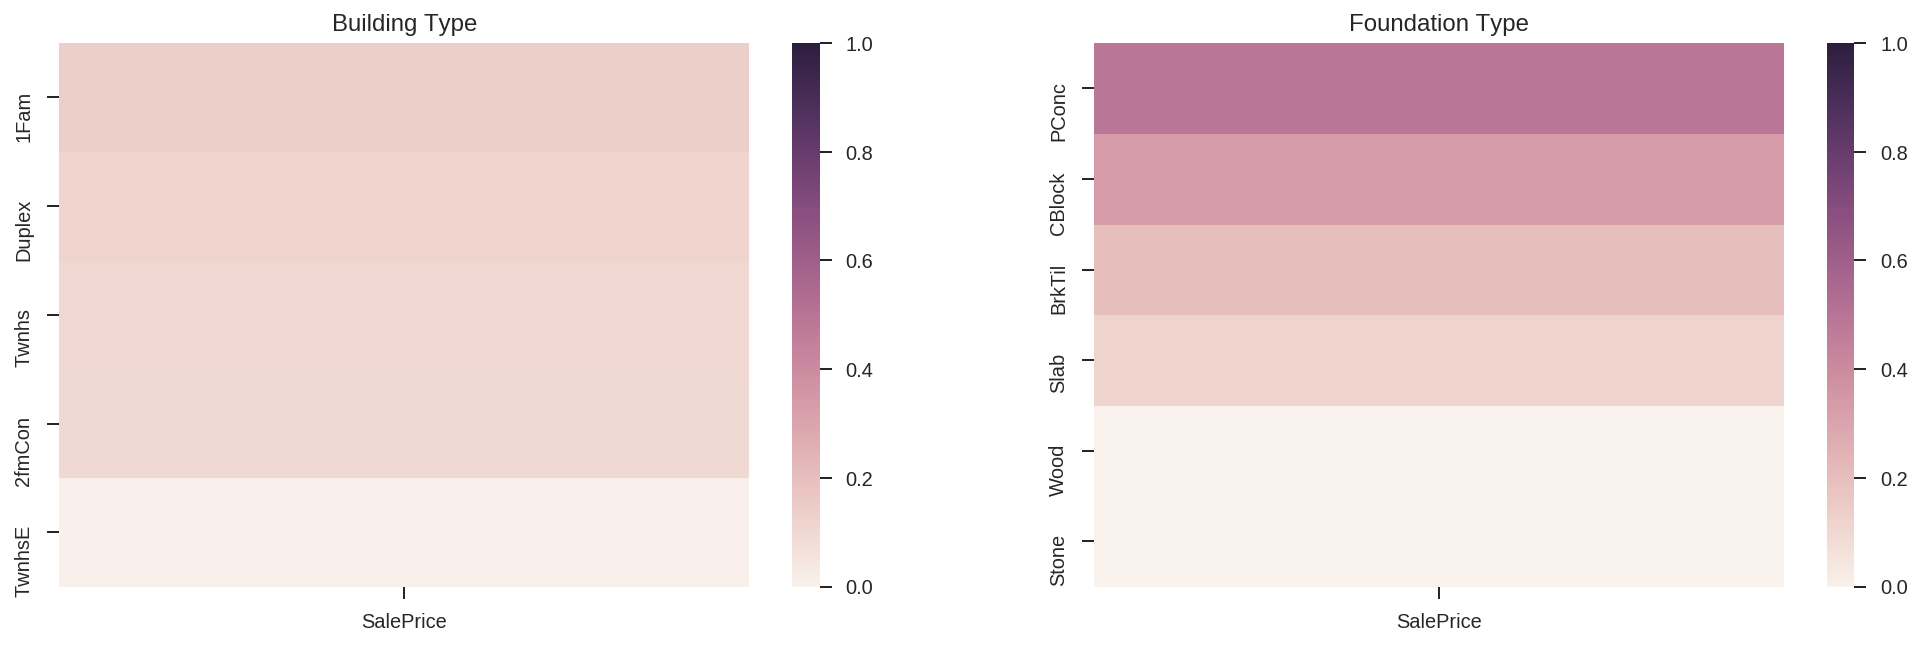

In [24]:
fig,(ax1,ax2) = plt.subplots(figsize=(17,5),nrows=1,ncols=2)

sns.heatmap(abs_bldg_corr[1:], vmin=0, vmax=1, ax = ax1);
sns.heatmap(abs_foun_corr[1:], vmin=0, vmax=1, ax = ax2);

ax1.set_title('Building Type')
ax2.set_title('Foundation Type')
# Very low correlation between building type and sale price

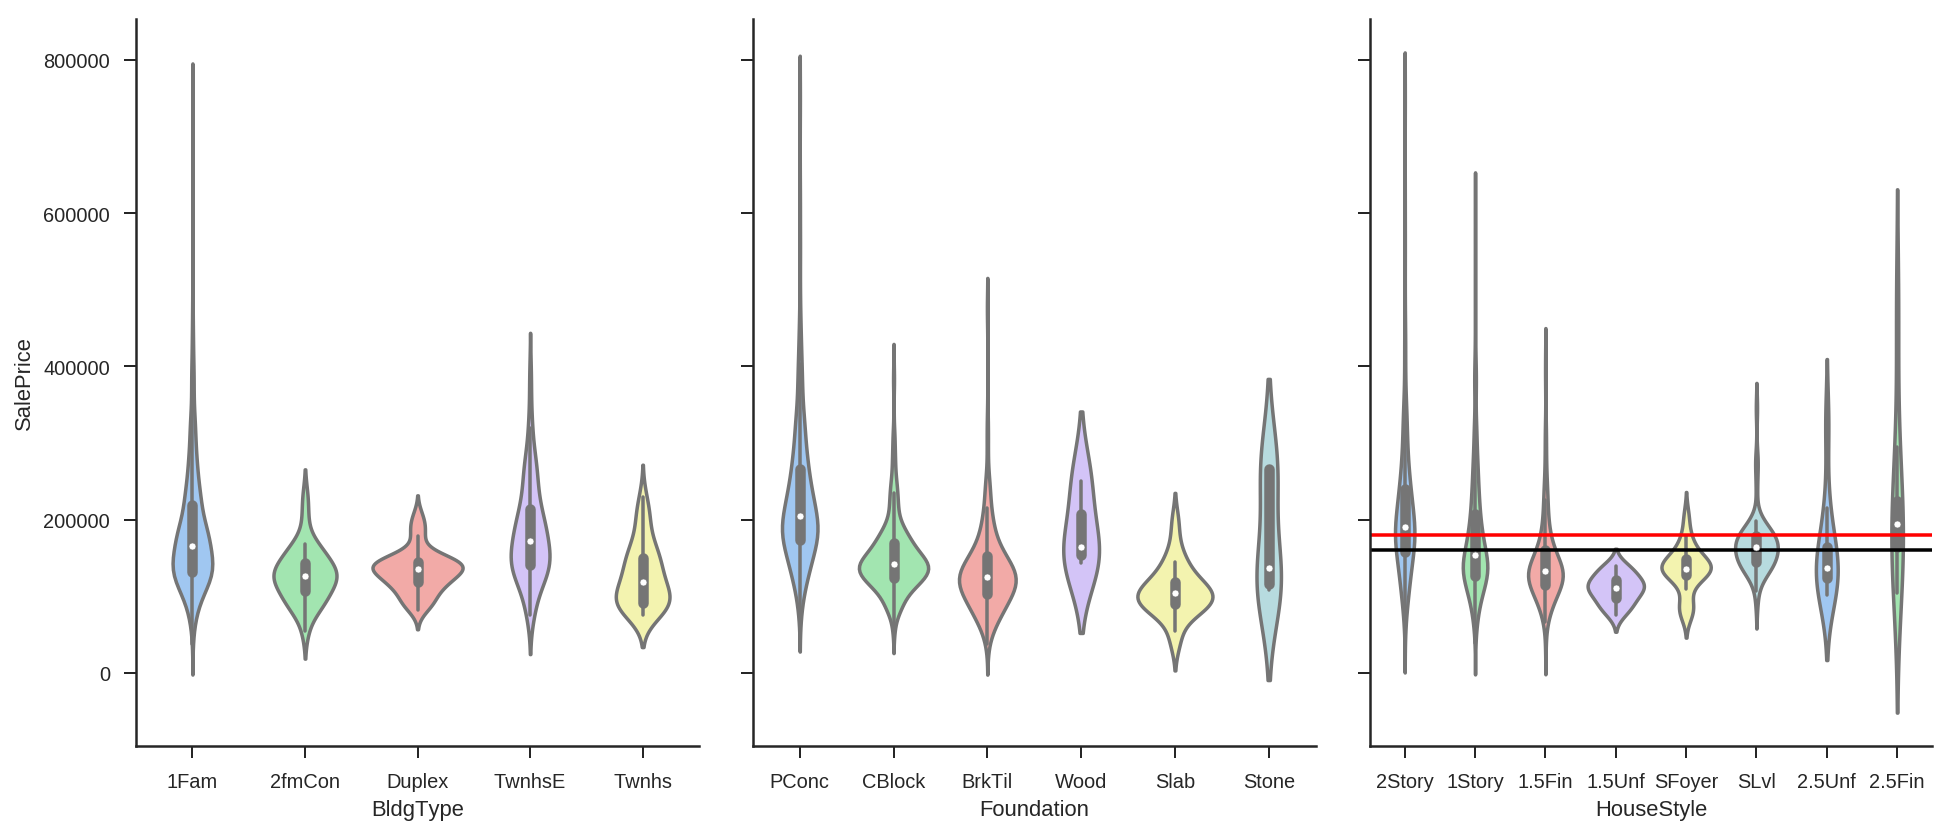

In [25]:
#fig, ax = plt.subplots(figsize=(17,5))
#sns.factorplot(kind='bar',x='BldgType',y='SalePrice', hue='Foundation', data=res_df,ax=ax)

g = sns.PairGrid(res_df,
                 x_vars=["BldgType", "Foundation", "HouseStyle"],
                 y_vars=["SalePrice"],
                 aspect=.75, size=6, )
g.map(sns.violinplot, palette="pastel");

# plot mean and median line
x= plt.gca().axes.get_xlim()
mean = res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

##### Renos?

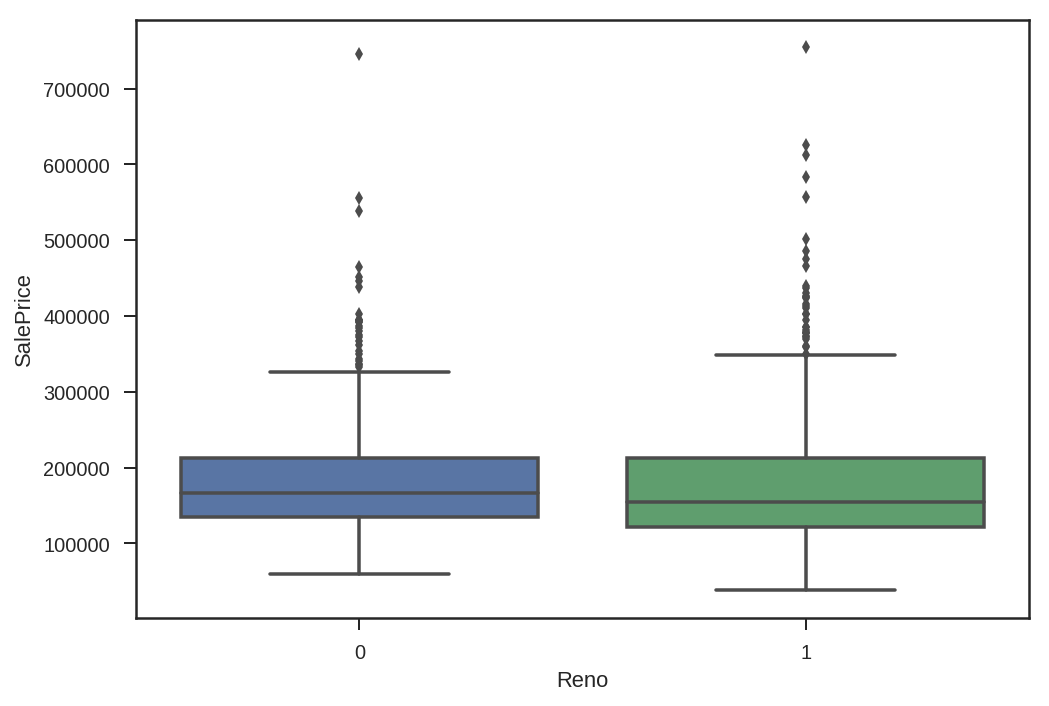

In [26]:
sns.boxplot(x="Reno", y="SalePrice",  data=res_df);

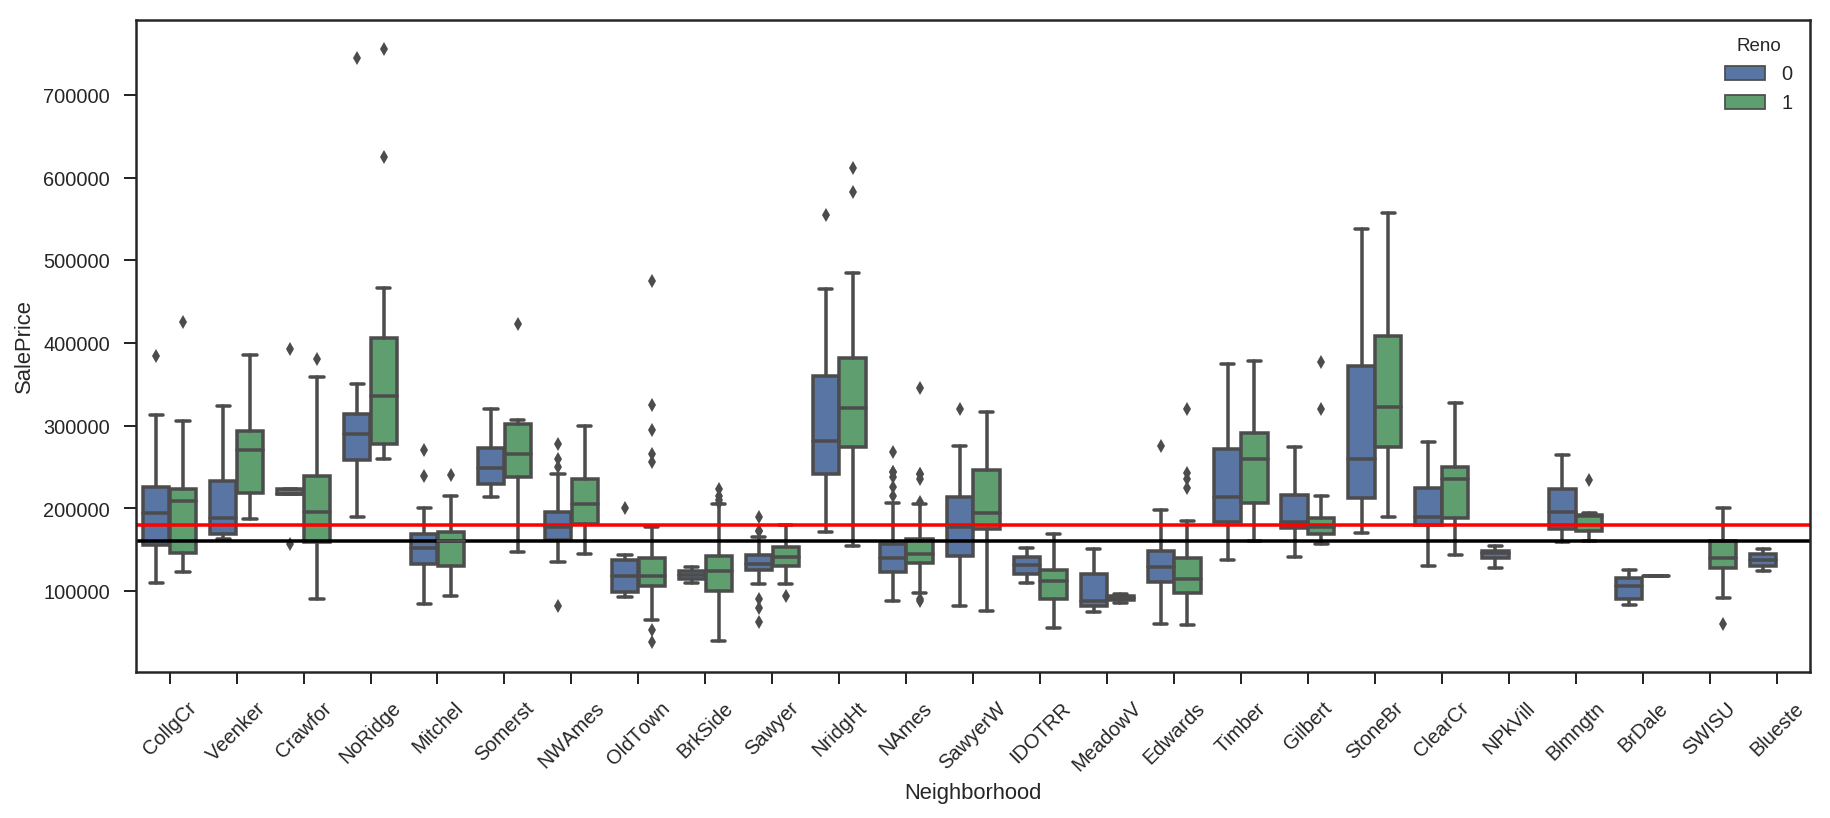

In [27]:
#sns.jointplot(x='Reno',y='SalePrice', data=res_df)
ax, fig = plt.subplots(figsize=(15,6))

sns.boxplot(x="Neighborhood", y="SalePrice", hue="Reno", data=res_df);
plt.xticks(rotation=45);

# plot mean and median line
x= plt.gca().axes.get_xlim()
mean = res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# Houses in particular neighbourhoods which have not been renovated have higher sales prices

In [28]:
res_df[['SaleType', 'SaleCondition', 'SalePrice']]


,SaleType,SaleCondition,SalePrice
0,WD,Normal,208500
1,WD,Normal,181500
2,WD,Normal,223500
3,WD,Abnorml,140000
4,WD,Normal,250000
5,WD,Normal,143000
6,WD,Normal,307000
7,WD,Normal,200000
8,WD,Abnorml,129900
9,WD,Normal,118000


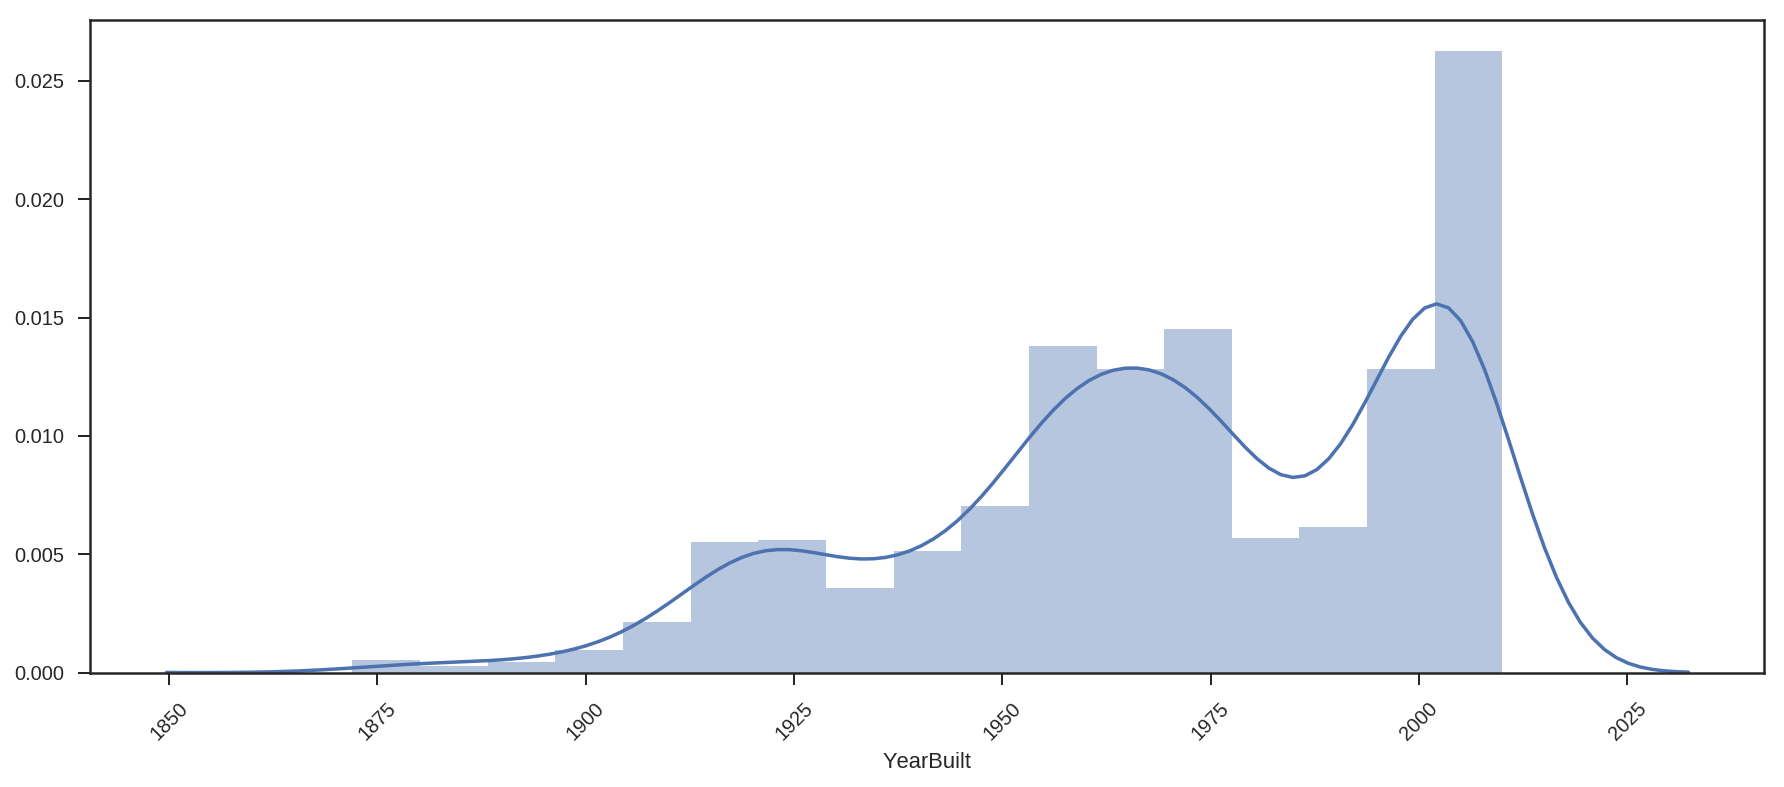

In [29]:
# Distribution of houses sold based on the year they were built
ax, fig = plt.subplots(figsize=(15,6))
ax = sns.distplot(res_df['YearBuilt']);
plt.xticks(rotation=45);

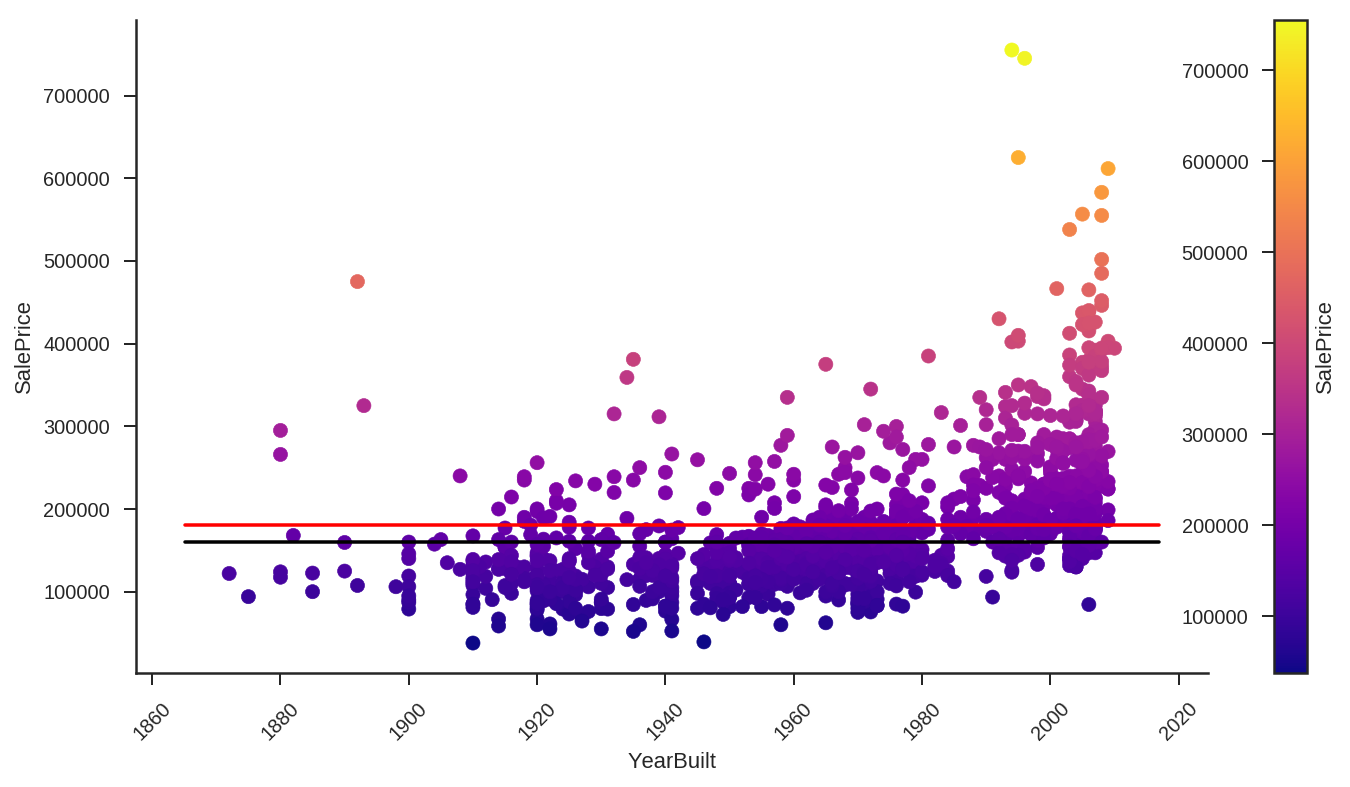

In [30]:
# Does the year a house was build influence the sale price?
fig,ax = plt.subplots(figsize=(12,6))

# plot sales by year 
res_df.plot(kind="scatter", x='YearBuilt', y='SalePrice', c='SalePrice', cmap="plasma", ax=ax, s=50);

# plot mean and median 
x= plt.gca().axes.get_xlim()
mean =res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# formatting
plt.xticks(rotation=45);
sns.despine( )


# Houses built in the late '80s and up to now had higher sales prices

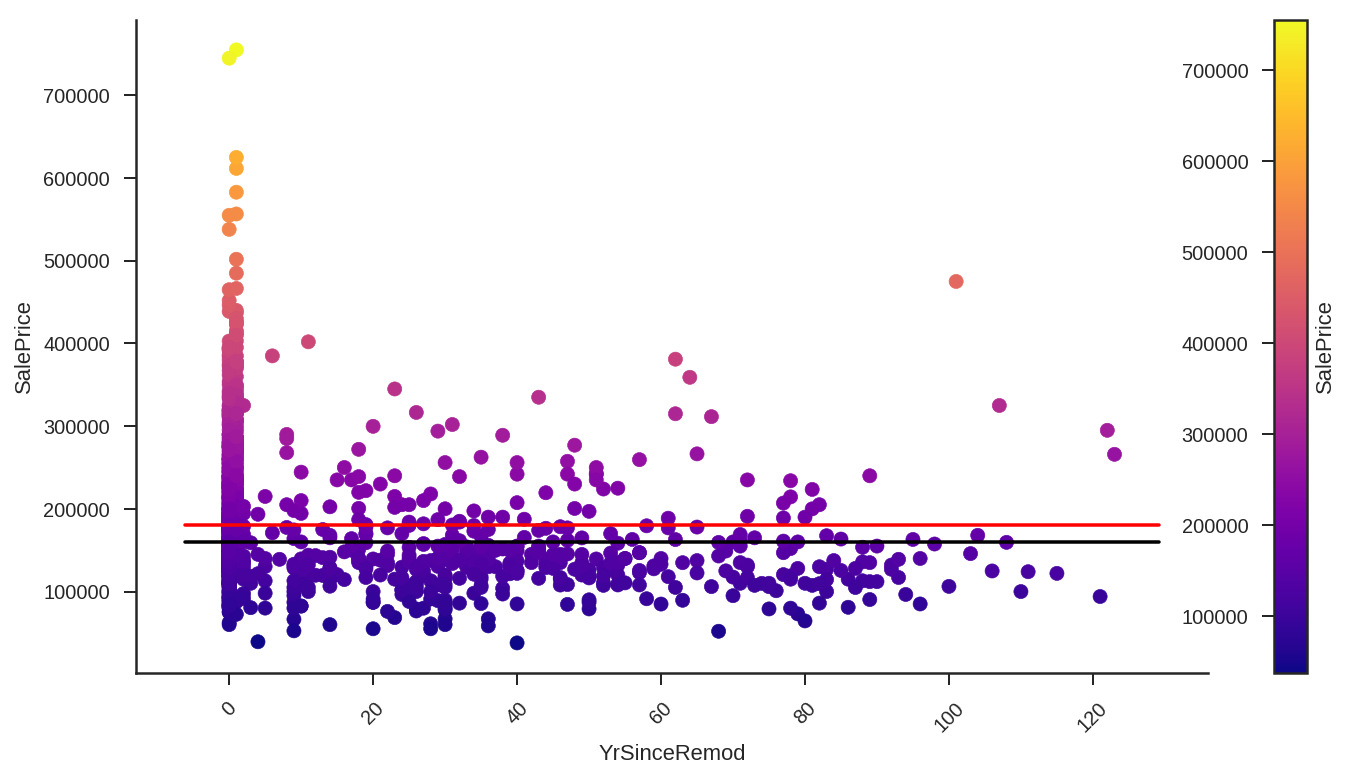

In [31]:
#Is there a difference in sales price based on years since last renovated?

fig,ax = plt.subplots(figsize=(12,6))

# plot sales by year 
res_df.plot(kind="scatter", x='YrSinceRemod', y='SalePrice', c='SalePrice', cmap="plasma", ax=ax, s=50);

# plot mean and median 
x= plt.gca().axes.get_xlim()
mean =res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# formatting
plt.xticks(rotation=45);
sns.despine( )

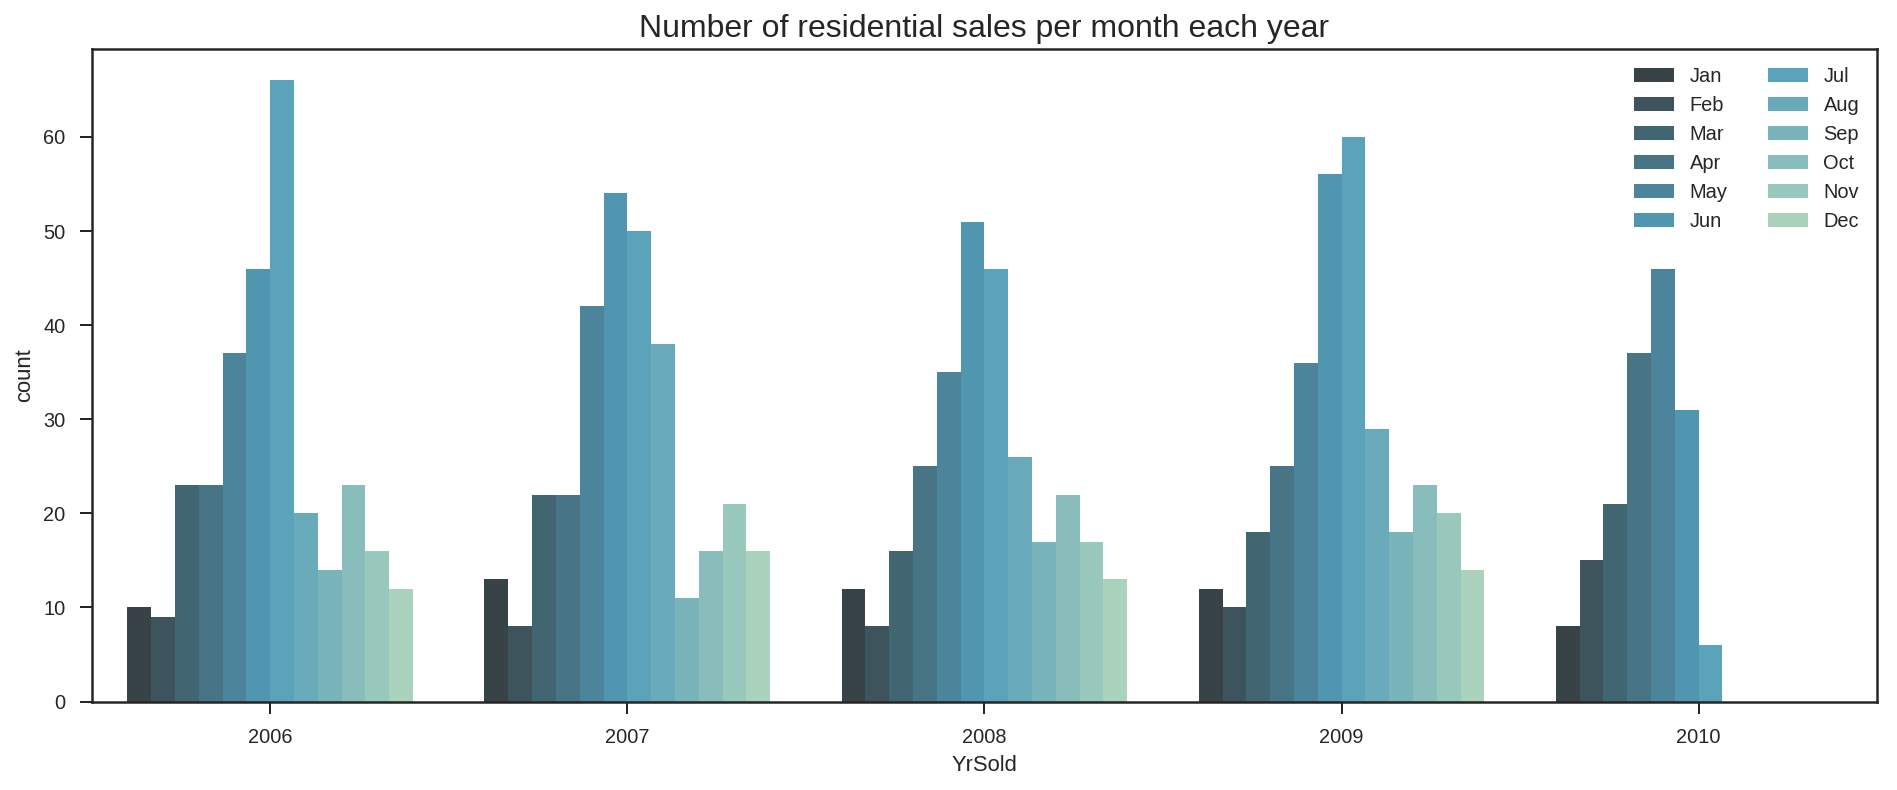

In [32]:
# Is there a difference in sales between months and years?
# Number of sales per month each year
fig, ax = plt.subplots(figsize=(16,6))
ax = sns.countplot(x="YrSold", data=res_df, hue='MoSold', palette="GnBu_d");
ax.legend(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'],
          loc='upper right', ncol=2)
sns.plt.title('Number of residential sales per month each year', fontsize=16)

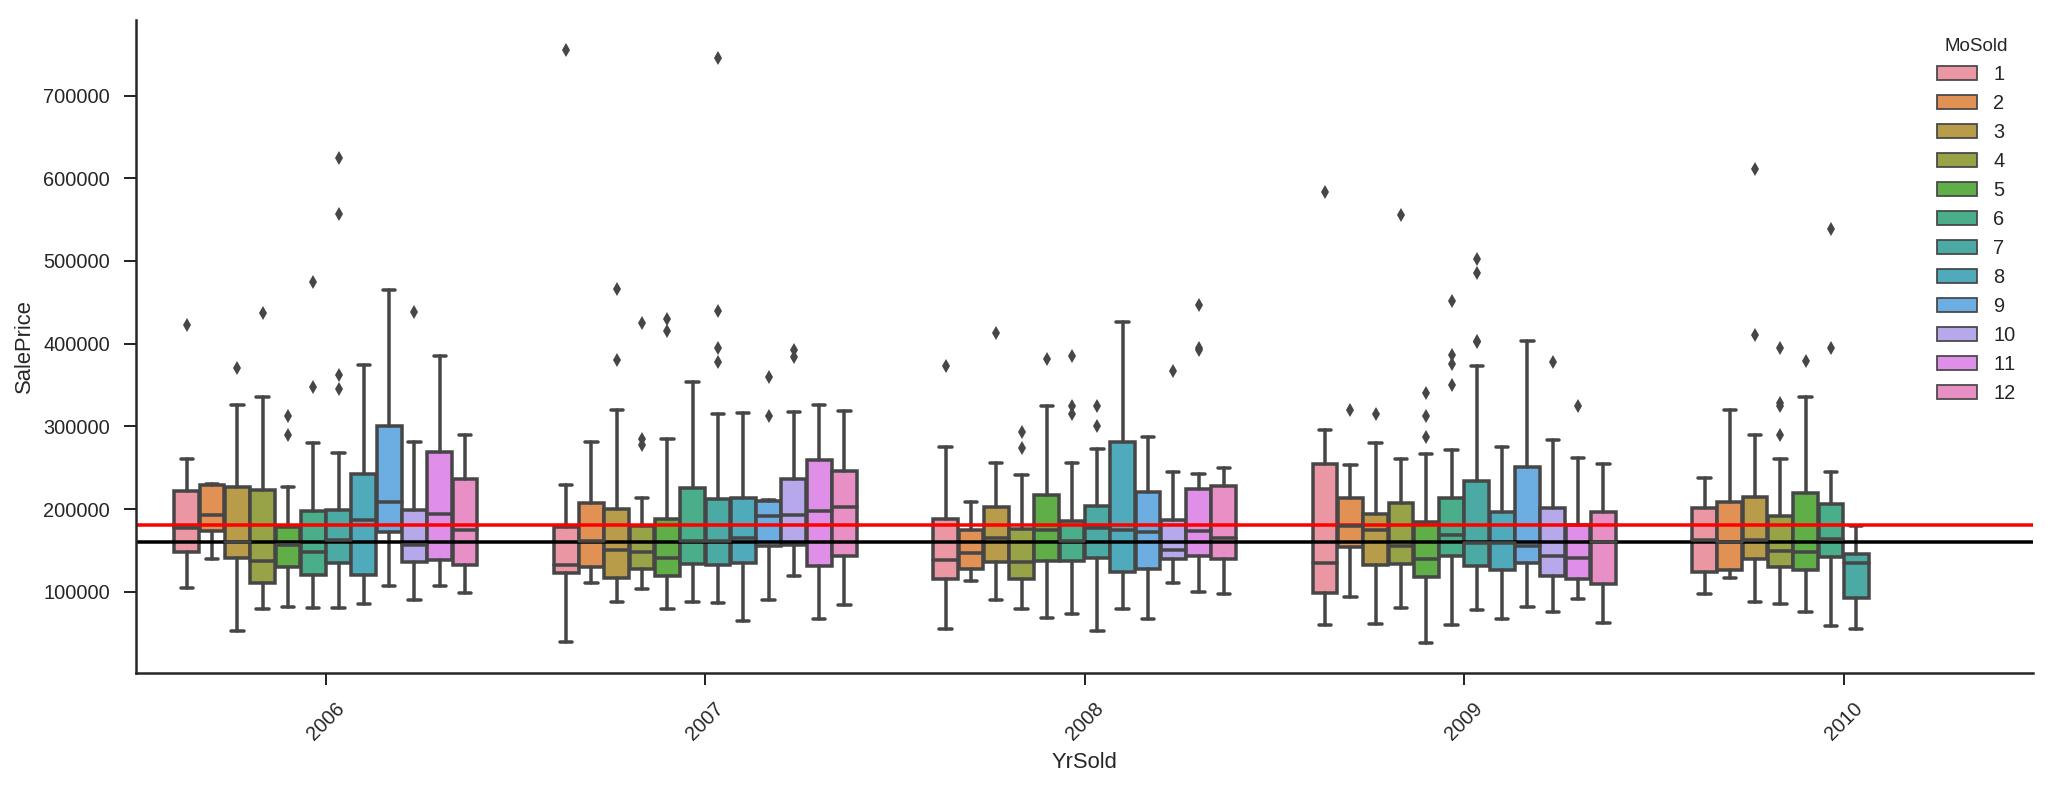

In [33]:
# Price based on time of year sold
fig,(ax) = plt.subplots(figsize=(17,6)) #,nrows=2,ncols=1)

# plot sales by year 
#res_df.plot(kind="scatter", x='MoSold', y='SalePrice', c='SalePrice', cmap="plasma", ax=ax, s=50);
#sns.barplot(x='YrSold',y='SalePrice', hue='MoSold', data=res_df, ax=ax1)
sns.boxplot(x="YrSold", y="SalePrice", hue="MoSold", data=res_df) #, ax=ax2);

# plot mean and median 
x= plt.gca().axes.get_xlim()
mean =res_df['SalePrice'].mean()
median = res_df['SalePrice'].median()
plt.plot(x, len(x)*[median], color='k'), plt.plot(x, len(x)*[mean], color='r');

# formatting
plt.xticks(rotation=45);
sns.despine( )

In [34]:
# Categorical variables correlated with sale price
obs = colinf[colinf['type'] == object]
ob = obs.variable.values

dum_df = pd.DataFrame(res_df[ob])
dum_df['SalePrice'] = res_df['SalePrice']

t_dummies_df = pd.get_dummies(dum_df,drop_first=True)
f_dummies_df = pd.get_dummies(dum_df,drop_first=False)

In [35]:
true_correlations = abs(t_dummies_df.corr())
true_correlations = true_correlations.sort_values(by='SalePrice',axis=0,ascending=False)
sale_corr_true = pd.DataFrame(true_correlations.loc[:,'SalePrice'])
t_hig_dum_corr = sale_corr_true[sale_corr_true['SalePrice'] > .3].sort_values(by='SalePrice',axis=0,ascending=False)
 
false_correlations = abs(f_dummies_df.corr())
false_correlations = false_correlations.sort_values(by='SalePrice',axis=0,ascending=False)
sale_corr_false = pd.DataFrame(false_correlations.loc[:,'SalePrice'])
f_hig_dum_corr = sale_corr_false[sale_corr_false['SalePrice'] > .3].sort_values(by='SalePrice',axis=0,ascending=False)

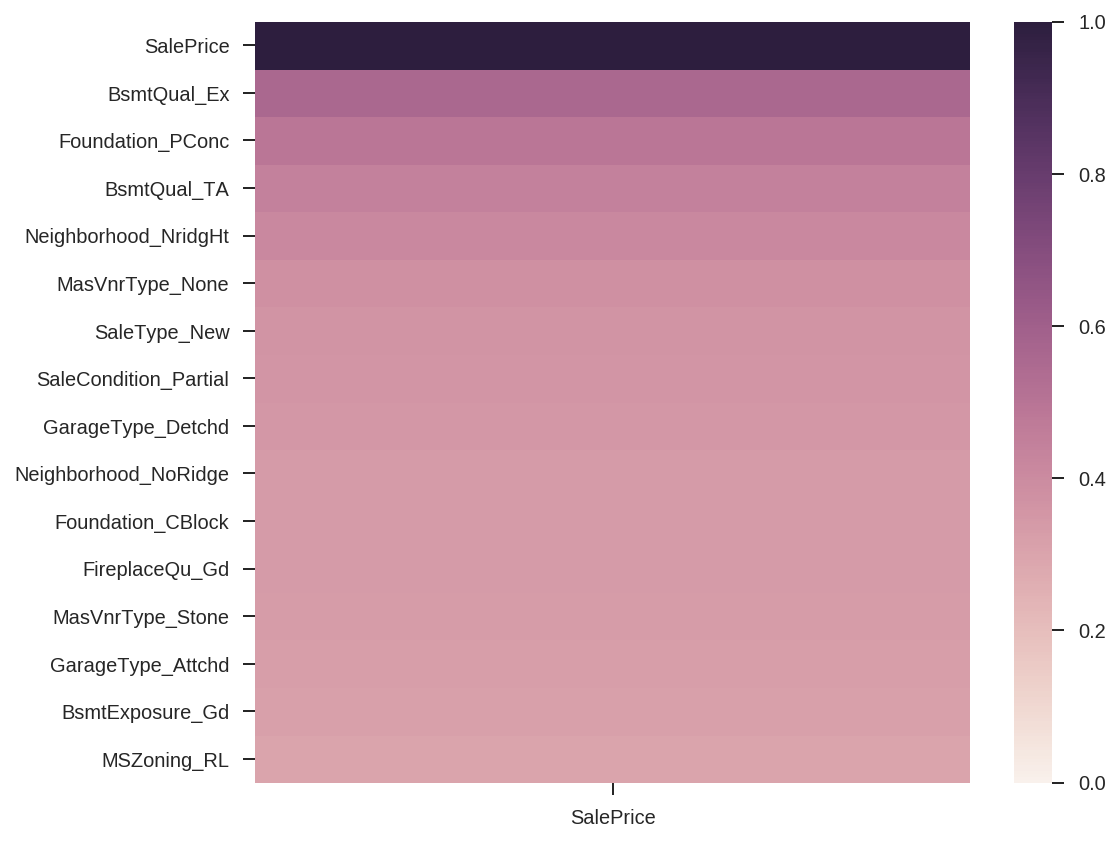

In [36]:
fig, ax = plt.subplots(figsize=(8,7)) #, ncols=2, nrows=1)
#sns.heatmap(t_hig_dum_corr, vmin=0, vmax=1, ax=ax1);
sns.heatmap(f_hig_dum_corr, vmin=0, vmax=1); #, ax=ax2);

cat_corr_list = list(t_hig_dum_corr.index)

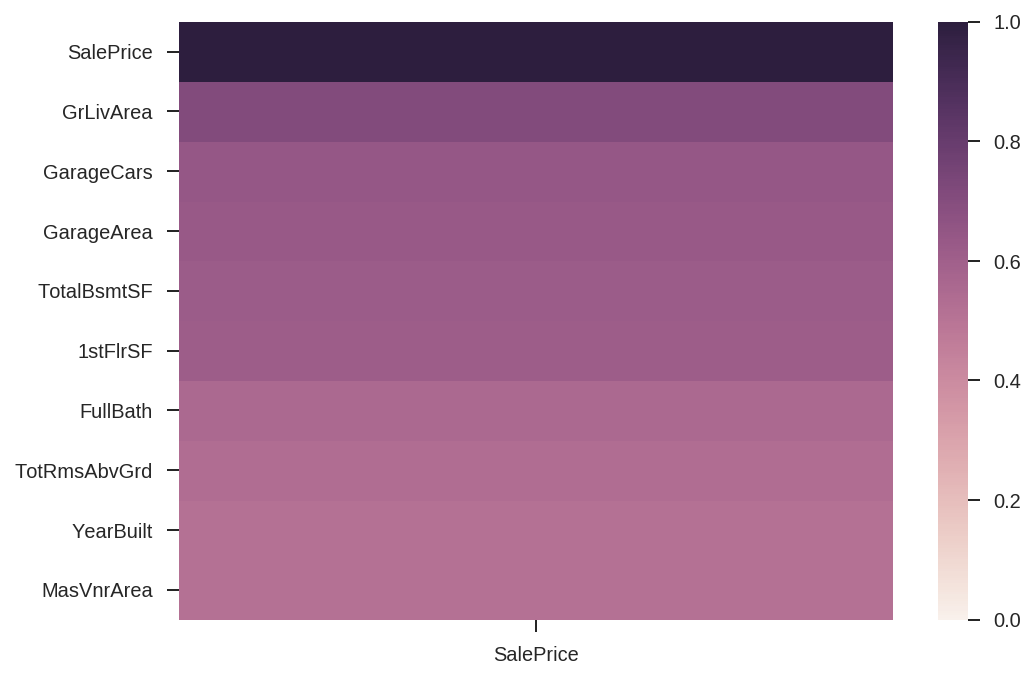

In [37]:
# Find the continuous variables most correlated with SalePrice
abs_corr = abs(res_df.corr())
high_corr = abs_corr[abs_corr['SalePrice'] >.5]
high_corr= high_corr.sort_values(by='SalePrice',axis=0,ascending=False)
high_corr = high_corr[['SalePrice']]
sns.heatmap(high_corr, vmin=0, vmax=1);

contin_corr_list = list(high_corr.index)

# Strong correlations between price and GrLivArea, GarageCars, BarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt and MasVnrArea

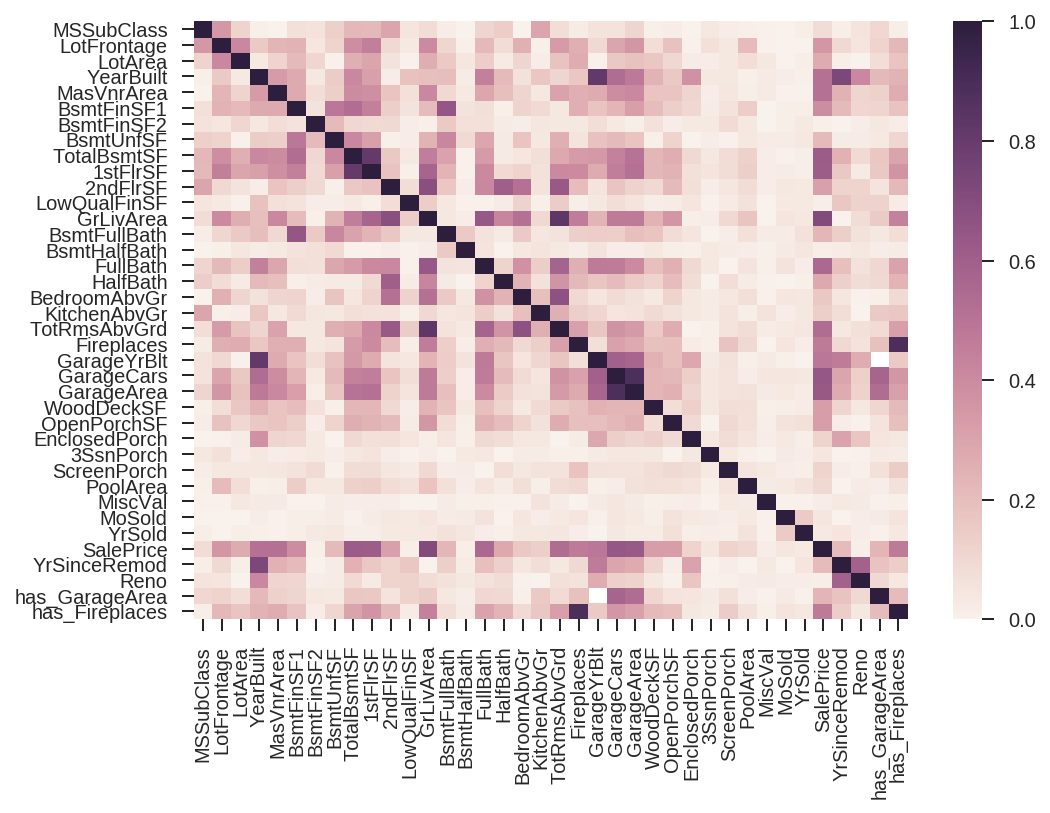

In [38]:
# Are any of the correlated variables with SalePrice correlated with other variables (multicollinearity)
abs_corr = abs(res_df.corr())
sns.heatmap(abs_corr, vmin=0, vmax=1);

## Final selection of variables for model

In [39]:
# get dummies for categorical variables, drop sale price from dummy df
f_dummies_df.drop('SalePrice', axis=1, inplace=True)

# Concatinate residential and dummy dfs
clean_df = pd.concat([res_df,f_dummies_df], axis=1)

# Drop columns used for dummy variables
clean_df.drop(labels=objs, axis=1,inplace=True)

In [40]:
all_final_df = pd.DataFrame(data=clean_df)
all_final_df.drop(['LotFrontage','GarageYrBlt','MasVnrArea'], axis=1, inplace=True)

## Set target and predictors

In [41]:
from sklearn.preprocessing import StandardScaler

X = all_final_df.drop('SalePrice', axis=1)
y = all_final_df['SalePrice'] 

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=42)

## Linear Regression with sklearn

In [44]:
lm = LinearRegression()
lm_model = lm.fit(X_train, y_train)
print ('Train score: {}\nTest score: {}'.format(lm_model.score(X_train, y_train), 
                                                lm_model.score(X_test, y_test)))
cross_val_score(lm_model, X_test, y=y_test, n_jobs=4, cv=10)
lm_y_pred = lm_model.predict(X_test)
lm_coef = lm_model.coef_
mse = mean_squared_error(y_test, lm_y_pred)
rsqr = r2_score(y_test, lm_y_pred)
print ('Mean square error: {}'.format(mse))

Train score: 0.882646695142
Test score: -2.49352067407e+25
Mean square error: 1.86436974865e+35


## Linear Regression with ridge regularisation

In [45]:
# Function to find best alpha and fit model
def ridge_regression(X, y):

    # create set of alphas 
    ridge_alphas = np.logspace(0, 5, 200)
    # run through set of alphas to find optimal value
    optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
    # Fit optimal ridge value to model
    optimal_ridge.fit(X, y)
    
    ridge = Ridge(alpha=optimal_ridge.alpha_)
    # get cross_val scores for ridge model
    ridge_scores = cross_val_score(ridge, X, y, cv=10, n_jobs=4)
       
    print ('Optimal ridge: {}\nRidge_scores: {}\nMean score: {}'.format(
    optimal_ridge.alpha_, ridge_scores, np.mean(ridge_scores)))
    return (np.mean(ridge_scores))

### Ridge with all columns

In [46]:
train_rig_all = ridge_regression(X_train, y_train)
test_rig_all = ridge_regression(X_test, y_test)
train_rig_all, test_rig_all

Optimal ridge: 690.551352016
Ridge_scores: [ 0.82387047  0.83803759  0.87435394  0.90500705  0.67230912  0.59108873
  0.88696829  0.81864969  0.85392773  0.79289622]
Mean score: 0.80571088433
Optimal ridge: 204.907468982
Ridge_scores: [ 0.82803451  0.71565026  0.92239468  0.76801651  0.74538496  0.85577164
  0.64548495  0.8517954   0.68933388  0.49673041]
Mean score: 0.751859719965


(0.80571088433011018, 0.75185971996546175)

### Ridge regression with dropped columns with few values, outliers

In [47]:
drops = ['LowQualFinSF','BsmtFinSF2','KitchenAbvGr','GarageArea','EnclosedPorch','3SsnPorch','ScreenPorch',
         'MiscVal','PoolArea','LowQualFinSF','LotArea']
drops_cols = [col for item in drops for col in all_final_df.columns  if item in col ]

dropped_df = all_final_df.drop(drops_cols, axis=1)
X = dropped_df.drop('SalePrice', axis=1)

Xs = ss.fit_transform(X)
y = dropped_df.SalePrice.values

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=42)

train_rig_drop = ridge_regression(X_train, y_train)
test_rig_drop = ridge_regression(X_test, y_test)

train_rig_drop, test_rig_drop

Optimal ridge: 517.09202429
Ridge_scores: [ 0.82258978  0.83667066  0.8829464   0.89439256  0.67311681  0.60294178
  0.89546097  0.82181548  0.88400047  0.7731312 ]
Mean score: 0.808706611544
Optimal ridge: 182.518349432
Ridge_scores: [ 0.82315078  0.66356112  0.91685584  0.79899436  0.73117464  0.84728819
  0.63768168  0.85081213  0.78100536  0.45003966]
Mean score: 0.750056375908


(0.80870661154410262, 0.75005637590753582)

## Linear Regression with statsmodels

In [48]:
import statsmodels.api as sm

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=42)

sm_model = sm.OLS(y_train, X_train).fit()
sm_model.summary()

/home/dsi-student/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     47.28
Date:                Fri, 01 Sep 2017   Prob (F-statistic):               0.00
Time:                        16:26:13   Log-Likelihood:                -12898.
No. Observations:                1108   AIC:                         2.609e+04
Df Residuals:                     963   BIC:                         2.681e+04
Df Model:                         144                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5333.7438   4565.867     -1.168      0.243   -1.43e+04    3626.453
x2          1.241e+04   3196.447      3.884      0.000    6140.717    1.87e+04
x3          1032.9552   2842.710      0.363      0.716   -4545.666    6611.576
x4         -4081.8881   2857.103     -1.429      0.153   -9688.755    1524.979
x5          4680.1408   3517.329      1.331      0.184   -2222.373    1.16e+04
x6          1.221e+04   9923.983      1.231      0.219   -7260.783    3.17e+04
x7          2.554e+04   1.07e+04      2.392      0.017    4589.462    4.65e+04
x8          3538.0598   1.33e+04      0.265      0.791   -2.26e+04    2.97e+04
x9          2639.2193   1421.679      1.856      0.064    -150.726    5429.165
x10         1291.0382   1022.051      1.263      0.207    -714.665    3296.742
x11         5189.5008   1716.958      3.022      0.003    1820.090    8558.911
x12         2633.0525   1488.143      1.769      0.077    -287.325    5553.430
x13        -3335.1377   1567.100     -2.128      0.034   -6410.463    -259.813
x14         5544.6936   2187.695      2.534      0.011    1251.494    9837.893
x15         5641.6168   2260.696      2.496      0.013    1205.158    1.01e+04
x16         9610.8935   1742.416      5.516      0.000    6191.524     1.3e+04
x17         2311.5254   1049.903      2.202      0.028     251.164    4371.887
x18          177.0319   1071.680      0.165      0.869   -1926.066    2280.130
x19         -138.4114    945.507     -0.146      0.884   -1993.903    1717.080
x20         -339.9831    980.268     -0.347      0.729   -2263.690    1583.724
x21         5020.5441   1789.874      2.805      0.005    1508.042    8533.047
x22          926.6647   1246.603      0.743      0.457   -1519.706    3373.036
x23         -769.0831   1448.982     -0.531      0.596   -3612.610    2074.444
x24          752.9841   1020.562      0.738      0.461   -1249.797    2755.766
x25         -330.4344    959.368     -0.344      0.731   -2213.127    1552.258
x26          119.0460   1056.005      0.113      0.910   -1953.291    2191.383
x27          155.5332    543.484      0.286      0.775    -911.016    1222.082
x28         -155.5332    543.484     -0.286      0.775   -1222.082     911.016
x29          106.5449   1109.745      0.096      0.924   -2071.253    2284.343
x30         1390.8489   1285.072      1.082      0.279   -1131.016    3912.714
x31         -626.7949    578.678     -1.083      0.279   -1762.410     508.820
x32         1756.9720    961.557      1.827      0.068    -130.018    3643.961
x33        -2493.1514    933.298     -2.671      0.008   -4324.684    -661.619
x34          456.8584    595.045      0.768      0.443    -710.876    1624.593
x35        -2112.3095    841.130     -2.511      0.012   -3762.969    -461.650
x36          725.4878    856.040      0.847      0.397    -954.432    2405.408
x3

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


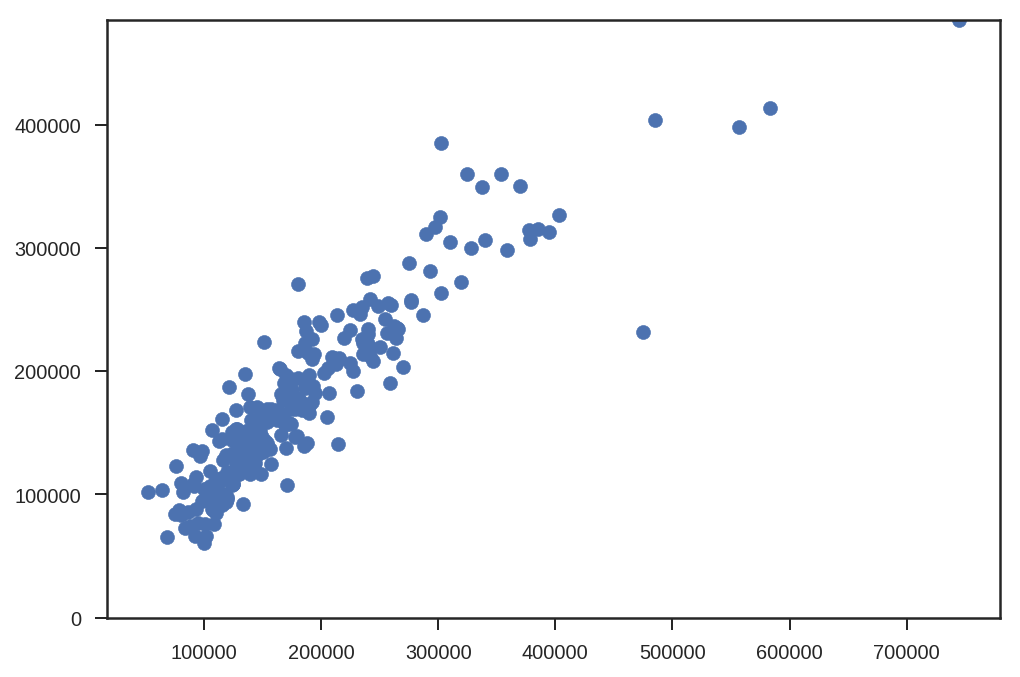

In [50]:
#fig, ax = plt.subplots()
sm_model_pred = pd.DataFrame()
sm_model_pred['y_pred'] = sm_model.predict(X_test)
sm_model_pred['SalePrice'] = y_test
sm_model_pred['Residuals'] = sm_model_pred['SalePrice'] - sm_model_pred['y_pred']
sm_model_pred
plt.ylim(-.5, sm_model_pred['y_pred'].max())
plt.scatter(sm_model_pred['SalePrice'], sm_model_pred['y_pred'])
#sns.lmplot(sm_model_pred['SalePrice'], sm_model_pred['y_pred'], data = sm_model_pred)

## Gridsearch

### Ridge

In [51]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=42)

parameters = {'alpha': np.logspace(0, 5, 200)}

rdg_gdsearch = GridSearchCV(Ridge(), parameters, n_jobs=4, cv=10)

rdg_gdsearch.fit(X_train, y_train)
best_alpha_ridge = rdg_gdsearch.best_params_
r_model = Ridge(alpha = best_alpha_ridge['alpha'])
r_model.fit(X_train, y_train)
#r_model.score(X_train, y_train), r_model.score(X_test, y_test)

rtrain_y_pred = r_model.predict(X_train)
rtest_y_pred = r_model.predict(X_test)

train_mse = mean_squared_error(y_train, rtrain_y_pred)
test_mse = mean_squared_error(y_test, rtest_y_pred)
print ('Train score: {}\nMean squared error:{}\nTest score: {}\nMean squared error:{}'.format
       (r_model.score(X_train, y_train), train_mse, r_model.score(X_test, y_test),  test_mse))

Train score: 0.856539703625
Mean squared error:875936561.992
Test score: 0.799579203404
Mean squared error:1498517634.36


#### Ridge Residuals

In [52]:
rig_y_pred = r_model.predict(Xs)
rig_residuals = rig_y_pred - y.mean()
rig_df = pd.DataFrame(res_df, columns=['SalePrice'])
rig_df['y_pred'] = rig_y_pred
rig_df['Residual'] = rig_residuals
rig_df.head()

,SalePrice,y_pred,Residual
0,208500,203792.875758,23656.592725
1,181500,196872.826208,16736.543175
2,223500,212394.365035,32258.082002
3,140000,181989.356034,1853.073001
4,250000,285025.023353,104888.740320


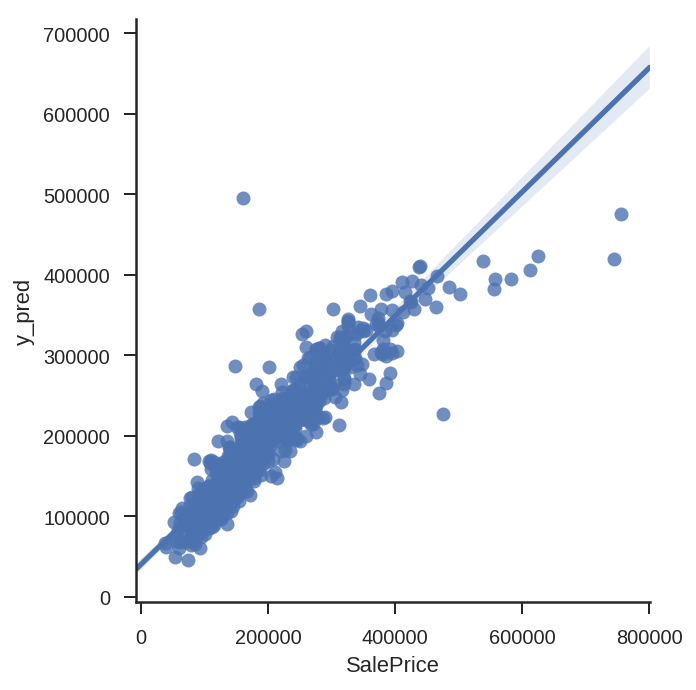

In [53]:
sns.lmplot(x='SalePrice', y='y_pred', data=rig_df)

### Lasso

In [54]:
parameters = {'alpha': np.logspace(0, 5, 200)}

lass_gdsearch = GridSearchCV(Lasso(), parameters, n_jobs=4, cv=10)

lass_gdsearch.fit(X_train, y_train)

best_alpha_las = lass_gdsearch.best_params_

l_model = Lasso(alpha = best_alpha_las['alpha'])
l_model.fit(X_train, y_train)

ltrain_y_pred = l_model.predict(X_train)
ltest_y_pred = l_model.predict(X_test)

train_mse = mean_squared_error(y_train, ltrain_y_pred)
test_mse = mean_squared_error(y_test, ltest_y_pred)
print ('Train score: {}\nMean squared error:{}\nTest score: {}\nMean squared error:{}'.format(l_model.score(X_train, y_train), train_mse, l_model.score(X_test, y_test), test_mse))

/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: 

Train score: 0.861274195037
Mean squared error:847028813.751
Test score: 0.824805279653
Mean squared error:1309905869.78


#### Lasso Residuals

In [55]:
lass_y_pred = l_model.predict(Xs)
lass_residuals = lass_y_pred - y.mean()

In [56]:
lass_df = pd.DataFrame(res_df, columns=['SalePrice'])
lass_df['y_pred'] = lass_y_pred
lass_df['Residual'] = lass_residuals
lass_df.head()

,SalePrice,y_pred,Residual
0,208500,201140.093667,21003.810634
1,181500,197743.832953,17607.549920
2,223500,208160.182675,28023.899642
3,140000,192360.471270,12224.188237
4,250000,296935.999220,116799.716187


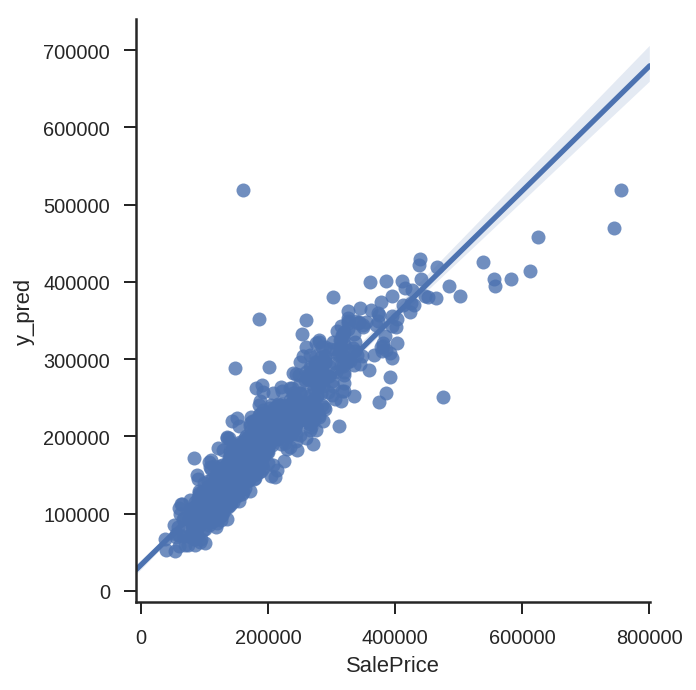

In [57]:
sns.lmplot(x='SalePrice', y='y_pred', data=lass_df)

### Support Vector Regression

In [58]:
from sklearn.svm import SVR

In [59]:
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#y_rbf = svr_rbf.fit(X, y).predict(X)

In [60]:
#svr_lin = SVR(kernel='linear', C=1e3)
#y_lin = svr_lin.fit(X, y).predict(X)

#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
#y_poly = svr_poly.fit(X, y).predict(X)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Clean data

In [61]:
renovate_cols = [col for col in df.columns if col not in res_cols]
renovate_df = pd.DataFrame(df[renovate_cols])
renovate_df.drop('Id', axis=1, inplace = True)

In [62]:
reno_dummies = pd.get_dummies(renovate_df)

In [63]:
clean_reno_df = pd.concat([renovate_df, reno_dummies],axis=1)
clean_reno_df['MSZoning'] = df['MSZoning']

In [64]:
# Get column information 
colinf=column_info(renovate_df)# Drop categorical columns
objs = colinf[colinf['type'] == object] #.sort_values(by='total')
objs = objs['variable'].values

# Drop columns used for dummy variables
clean_reno_df.drop(labels=objs, axis=1,inplace=True)

In [65]:
clean_reno_df = clean_reno_df[ (clean_reno_df['MSZoning'] == 'RL') | (clean_reno_df['MSZoning'] == 'RH') | (clean_reno_df['MSZoning'] == 'RP') | (clean_reno_df['MSZoning'] == 'RM')]
clean_reno_df.drop('MSZoning', axis=1, inplace=True)

In [66]:
df.shape, res_df.shape, clean_reno_df.shape

((1460, 87), (1385, 63), (1385, 118))

### Lasso on residuals

#### Set target and predictors, standardise 

In [67]:
# residuals of model are the ys
# X renovatable

rX = clean_reno_df.drop('SalePrice', axis=1)
ry = lass_residuals

rXs = ss.fit_transform(rX)

In [68]:
rX_train, rX_test, ry_train, ry_test = train_test_split(rXs, ry, test_size=0.20, random_state=42)

#### Fit model to residuals

In [69]:
parameters = {'alpha': np.logspace(0, 5, 200)}

lass_gdsearch = GridSearchCV(Lasso(), parameters, n_jobs=4, cv=10)

lass_gdsearch.fit(rX_train, ry_train)

best_alpha_las = lass_gdsearch.best_params_
l_model = Lasso(alpha = best_alpha_las['alpha'])
l_model.fit(rX_train, ry_train)
#l_model.score(rX_train, ry_train), l_model.score(rX_test, ry_test)

ltrain_y_pred = l_model.predict(rX_train)
ltest_y_pred = l_model.predict(rX_test)

train_mse = mean_squared_error(ry_train, ltrain_y_pred)
test_mse = mean_squared_error(ry_test, ltest_y_pred)
print ('Train score: {}\nMean squared error:{}\nTest score: {}\nMean squared error:{}'.format(l_model.score(rX_train, ry_train), train_mse, l_model.score(rX_test, ry_test), test_mse))

#print ('Train score: {}\nTest score: {}'.format
#       (l_model.score(rX_train, ry_train), l_model.score(rX_test, ry_test)))

/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dsi-student/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: 

Train score: 0.749432786949
Mean squared error:1231311766.21
Test score: 0.682034744307
Mean squared error:1443098978.67


In [70]:
#plot residuals and prediction of residuals
lass_residuals_y_pred = l_model.predict(rXs)
lass_residuals = lass_residuals_y_pred - ry.mean()

In [71]:
lass_res_df = pd.DataFrame(res_df, columns=['SalePrice'])
lass_res_df['y_pred'] = lass_residuals_y_pred
lass_res_df['Residual'] = rig_residuals
lass_res_df.head()

,SalePrice,y_pred,Residual
0,208500,47558.002690,23656.592725
1,181500,-18976.788716,16736.543175
2,223500,47387.049883,32258.082002
3,140000,13877.065546,1853.073001
4,250000,71406.329337,104888.740320


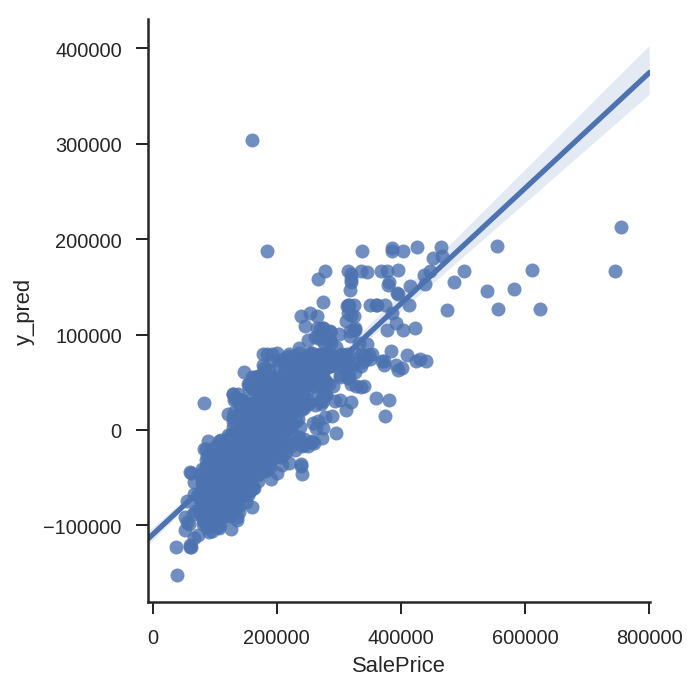

In [72]:
sns.lmplot(x='SalePrice', y='y_pred', data=lass_res_df)

In [73]:
lasso_var = pd.DataFrame(data = rX.columns, columns=['variable'])  
lasso_var['Coef'] = l_model.coef_

lasso_var[lasso_var['Coef'] != 0].sort_values(by='Coef', ascending=False)

,variable,Coef
0,OverallQual,30866.266137
84,KitchenQual_Ex,6692.683723
49,ExterQual_Ex,6592.022339
95,GarageFinish_Fin,6238.821251
2,YearRemodAdd,3480.661805
102,GarageQual_TA,3155.548563
96,GarageFinish_RFn,3066.520042
4,has_BsmtFinSF1,2892.713105
74,HeatingQC_Ex,2882.435625
5,OverallQual,2578.470121


### Ridge regression on residuals

#### Set target and predictors, standardise 

In [74]:
# residuals of model are the ys
# X renovatable

rX = clean_reno_df.drop('SalePrice', axis=1)
ry = rig_residuals

rXs = ss.fit_transform(rX)

In [75]:
rX_train, rX_test, ry_train, ry_test = train_test_split(rXs, ry, test_size=0.20, random_state=42)

#### Fit model to residuals

In [76]:
parameters = {'alpha': np.logspace(0, 5, 200)}

rig_gdsearch = GridSearchCV(Ridge(), parameters, n_jobs=4, cv=10)

rig_gdsearch.fit(rX_train, ry_train)

best_alpha_rig = rig_gdsearch.best_params_
r_model = Ridge(alpha = best_alpha_rig['alpha'])
r_model.fit(rX_train, ry_train)

rtrain_y_pred = r_model.predict(rX_train)
rtest_y_pred = r_model.predict(rX_test)

train_mse = mean_squared_error(ry_train, rtrain_y_pred)
test_mse = mean_squared_error(ry_test, rtest_y_pred)

print ('Train score: {}\nMean squared error:{}\nTest score: {}\nMean squared error:{}'.format
       (r_model.score(rX_train, ry_train), train_mse, r_model.score(rX_test, ry_test),  test_mse))

#print ('Train score: {}\nTest score: {}'.format
#       (r_model.score(rX_train, ry_train), r_model.score(rX_test, ry_test)))

Train score: 0.764662308584
Mean squared error:1069406937.21
Test score: 0.688728715101
Mean squared error:1267312548.78


In [77]:
#plot residuals and prediction of residuals
rig_residuals_y_pred = r_model.predict(rXs)
rig_residuals = rig_residuals_y_pred - ry.mean()

In [78]:
rig_res_df = pd.DataFrame(res_df, columns=['SalePrice'])
rig_res_df['y_pred'] = rig_residuals_y_pred
rig_res_df['Residual'] = rig_residuals
rig_res_df.head()

,SalePrice,y_pred,Residual
0,208500,49663.948727,50553.205265
1,181500,-20323.663123,-19434.406585
2,223500,49442.360811,50331.617349
3,140000,9186.619176,10075.875714
4,250000,67594.943179,68484.199717


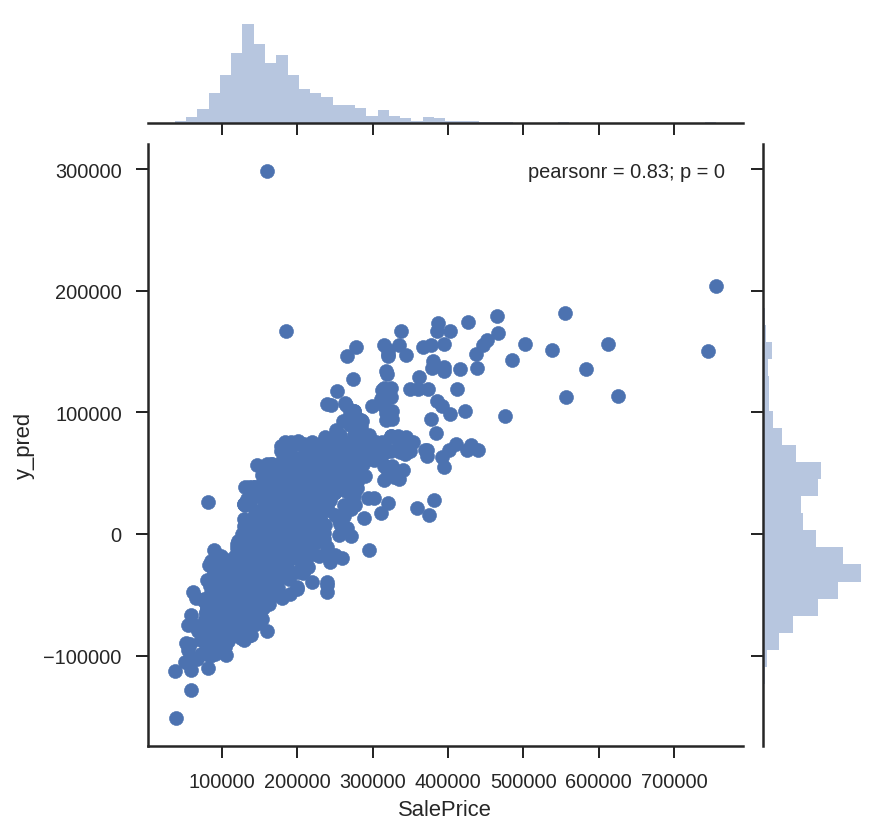

In [82]:
sns.jointplot(x='SalePrice', y='y_pred', data=rig_res_df)

In [80]:
ridge_var = pd.DataFrame(data = rX.columns, columns=['variable'])  
ridge_var['Coef'] = r_model.coef_
ridge_var[lasso_var['Coef'] != 0].sort_values(by='Coef', ascending=False)

,variable,Coef
0,OverallQual,12764.777796
5,OverallQual,12764.777796
49,ExterQual_Ex,7387.370523
84,KitchenQual_Ex,6819.169890
95,GarageFinish_Fin,4772.800806
102,GarageQual_TA,3333.409072
107,GarageCond_TA,3092.431909
74,HeatingQC_Ex,2293.347679
7,YearRemodAdd,2276.462851
2,YearRemodAdd,2276.462851


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [81]:
# A: